## Evaluation of TRIP pipeline results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from os import listdir
import numpy as np
from scipy import stats
from Bio.Seq import Seq
import seaborn as sn
import seaborn as sns
import itertools
from scipy.stats import gaussian_kde
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
import platform

In [2]:
# import pyranges as pr
import umap


c:\Users\nicol\anaconda3\envs\chromatin\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\nicol\anaconda3\envs\chromatin\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\nicol\anaconda3\envs\chromatin\lib\site-packages\umap\distances.py:1086: 

In [3]:
lsize=14
titlesize=16
axesthickness = 1.5
flierprops = dict(marker='o',markersize=1.5)
boxplot_kwargs = {'widths':0.65, 'vert':True, 'patch_artist':True, 'boxprops':dict(facecolor='#FEFBF3'), 'whis':[5, 95]}
bar_kwargs = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
plt.rcParams['axes.linewidth'] = axesthickness
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [4]:
# import final dataframe to filter datasets for visualizations (to visualize only barcodes that were used in the final analysis)
path = './04_Paper/02_github/epridict/datasets_for_ml/chromatin/'
encode_df_final = pd.read_csv(path+'encode_df.csv')
editingcollist = ['PE_edited_corrected_percentage', 'PE_unintended_editing_corrected_percentage', 'ABE8e_total_edited_corrected_percentage', 'BE4max_total_edited_corrected_percentage', 'Cas9_modified_corrected_percentage']
encode_df_final = encode_df_final.dropna(subset=[x for x in encode_df_final.columns if x not in editingcollist])

### Calculate barcode count distribution

In [5]:
path = './01_TRIP_pool/02_Analysis/NM_TRIP_analysis/pool/results/editing/analysis/'

def list_files(directory):
    return [f for f in listdir(directory) if ('TRIP-lib' in f) and not ('Ctrl' in f)]

filelist = list_files(path)

alleditorsbarcodecountdict = {}
value_all_editors = []
maxcount = 0
for file in filelist:
    editor = file.split('_')[2]
    replicate = file.split('_')[3]
    analysistable = pd.read_csv(path+file)
    if 'barcodecount' in analysistable.columns:
        analysistable = analysistable.rename(columns={'barcodecount':'totalreads'})
    toofewreads = analysistable[analysistable['totalreads']<100]
    counttable = analysistable[analysistable['totalreads']>=100]
    
    alleditorsbarcodecountdict[editor+'_'+replicate] = counttable
    tablelength = len(counttable)
    if tablelength > maxcount:
        maxcount = tablelength
    
    indexes = np.arange(len(counttable))
    values = list(counttable['totalreads'])
    values = [editor+'_'+replicate]+values
    value_all_editors.append(values)
    #plt.bar(indexes,values)
    #plt.show()
    
    
    
            
    print(editor, replicate, len(counttable))
    print('Omitted reads:',sum(toofewreads['totalreads']))
    print('Percentage of ommitted reads:',round(sum(toofewreads['totalreads'])/sum(analysistable['totalreads'])*100, 2))
    print('Used reads:',sum(counttable['totalreads']))
    print(max(counttable['totalreads']))

ABE8e 1 5164
Omitted reads: 1040154.0
Percentage of ommitted reads: 9.71
Used reads: 9667804.0
278750.0
ABE8e 2 5362
Omitted reads: 1281130.0
Percentage of ommitted reads: 10.07
Used reads: 11442281.0
354240.0
ABE8e 3 5632
Omitted reads: 1203886.0
Percentage of ommitted reads: 9.04
Used reads: 12106277.0
381118.0
BE4max 1 6243
Omitted reads: 1455141.0
Percentage of ommitted reads: 9.78
Used reads: 13426454.0
492610.0
BE4max 2 5669
Omitted reads: 1261675.0
Percentage of ommitted reads: 10.55
Used reads: 10701151.0
379761.0
BE4max 3 6288
Omitted reads: 1456150.0
Percentage of ommitted reads: 9.55
Used reads: 13799241.0
483050.0
Cas9 1 6466
Omitted reads: 2242866
Percentage of ommitted reads: 10.78
Used reads: 18571008
958973
Cas9 2 6877
Omitted reads: 2435532
Percentage of ommitted reads: 10.17
Used reads: 21518343
1135146
Cas9 3 7572
Omitted reads: 2945495
Percentage of ommitted reads: 10.82
Used reads: 24269133
1281409
PE 1 5597
Omitted reads: 1276530
Percentage of ommitted reads: 9.01

### Calculate editing for PE

--> according to 01_mapping_pipeline/src/20230415_TRIP_Editing_Analysis_PE.py

### Analyze editing of PE

In [6]:
minimumreadnumber = 100

path = './01_TRIP_pool/02_Analysis/NM_TRIP_analysis/pool/results/editing/analysis/'

def list_files_PE_editing(directory):
    return [f for f in listdir(directory) if "PE_editing_per_barcode" in f]

PEfilelist = list_files_PE_editing(path)
# sort PEfilelist
PEfilelist = sorted(PEfilelist)

df_templist = []
suffixlist = []
alleditorslist = []

for file in PEfilelist:
    df_temp = pd.read_csv(path+file)
    df_temp = df_temp.rename(columns={"Unnamed: 0":"barcode"})
    df_temp = df_temp.set_index('barcode')

    df_temp = df_temp[df_temp['totalreads']>=minimumreadnumber]

    
    editor = file.split('_')[2]
    replicate = file.split('_')[3]
    df_temp = df_temp.add_prefix(editor+'_'+replicate+'_')
    alleditorslist.append(editor+'_'+replicate)
    print(file)
    print(editor, replicate)
    print()
    df_templist.append(df_temp)
    
PE_combined_df = pd.concat(df_templist, axis=1)
PE_combined_df = PE_combined_df.dropna()

PE_combined_df["average_Ctrl_wt"] = PE_combined_df[['Ctrl_1_wt_percentage','Ctrl_2_wt_percentage','Ctrl_3_wt_percentage']].mean(axis=1)
PE_combined_df["average_Ctrl_unintended_editing"] = PE_combined_df[['Ctrl_1_unintended_editing_percentage','Ctrl_2_unintended_editing_percentage','Ctrl_3_unintended_editing_percentage']].mean(axis=1)
PE_combined_df["average_Ctrl_edited"] = PE_combined_df[['Ctrl_1_edited_percentage','Ctrl_2_edited_percentage','Ctrl_3_edited_percentage']].mean(axis=1)
# filter for < 5% unintended editing in control
PE_combined_df = PE_combined_df[PE_combined_df["average_Ctrl_unintended_editing"] < 0.05]

# get average of replicates for PE editing/unintended editing/wt
PE_combined_df["average_PE_wt"] = PE_combined_df[['PE_1_wt_percentage','PE_2_wt_percentage','PE_3_wt_percentage']].mean(axis=1)
PE_combined_df["average_PE_unintended_editing"] = PE_combined_df[['PE_1_unintended_editing_percentage','PE_2_unintended_editing_percentage','PE_3_unintended_editing_percentage']].mean(axis=1)
PE_combined_df["average_PE_edited"] = PE_combined_df[['PE_1_edited_percentage','PE_2_edited_percentage','PE_3_edited_percentage']].mean(axis=1)

# correct PE values with control values
PE_combined_df['PE_edited_corrected'] = PE_combined_df.apply(lambda x: ((x['average_PE_edited']-x['average_Ctrl_edited'])/(1-x['average_Ctrl_edited'])),axis=1)
PE_combined_df['PE_unintended_editing_corrected'] = PE_combined_df.apply(lambda x: ((x["average_PE_unintended_editing"]-x['average_Ctrl_unintended_editing'])/(1-x['average_Ctrl_unintended_editing'])),axis=1)                                                                                   

# clamp values of averageedited/indel/unedited to 0 to 1 to be consistent with prediction models
PE_combined_df['PE_edited_corrected'] = PE_combined_df['PE_edited_corrected'].clip(0,1)
PE_combined_df['PE_unintended_editing_corrected'] = PE_combined_df['PE_unintended_editing_corrected'].clip(0,1)
PE_combined_df['PE_wt_corrected'] = PE_combined_df.apply(lambda x: 1-x.PE_unintended_editing_corrected - x.PE_edited_corrected,axis=1)

# convert final values to percentages
PE_combined_df['PE_edited_corrected_percentage'] = PE_combined_df['PE_edited_corrected'].apply(lambda x: x*100)
PE_combined_df['PE_unintended_editing_corrected_percentage'] = PE_combined_df['PE_unintended_editing_corrected'].apply(lambda x: x*100)
PE_combined_df['PE_wt_corrected_percentage'] = PE_combined_df['PE_wt_corrected'].apply(lambda x: x*100)

PE_combined_df = PE_combined_df.dropna()

# Remove row with barcode ACCTCTCCGAAATCGT, since mapping is not in one of the main chromosomes (but a variant "chr1_KI270709v1_random")
PE_combined_df = PE_combined_df[PE_combined_df.index != 'ACCTCTCCGAAATCGT']




path = './01_TRIP_pool/02_Analysis/NM_TRIP_analysis/pool/results/editing/analysis/summary/'
PE_combined_df.to_csv(path+'20230415_TRIP_PE_corrected_editing_values.csv')



print('Total number of barcodes:',len(PE_combined_df))


20231415_TRIP-lib_Ctrl_1_PE_editing_per_barcode.csv
Ctrl 1

20231415_TRIP-lib_Ctrl_2_PE_editing_per_barcode.csv
Ctrl 2

20231415_TRIP-lib_Ctrl_3_PE_editing_per_barcode.csv
Ctrl 3

20231415_TRIP-lib_PE_1_PE_editing_per_barcode.csv
PE 1

20231415_TRIP-lib_PE_2_PE_editing_per_barcode.csv
PE 2

20231415_TRIP-lib_PE_3_PE_editing_per_barcode.csv
PE 3

Total number of barcodes: 4343


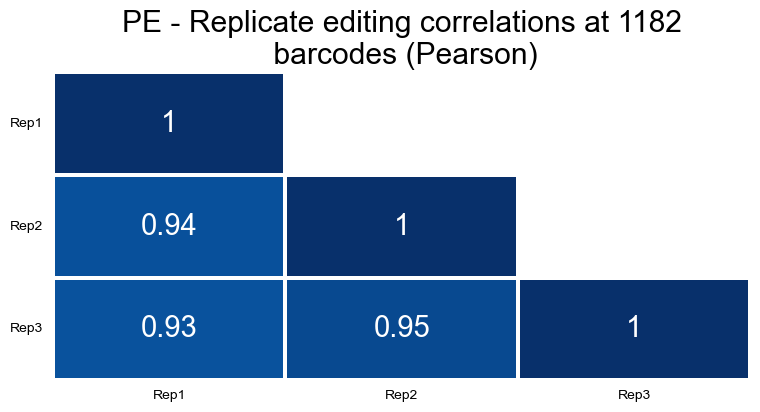

In [7]:
PE_replicate_editing_df = PE_combined_df.copy()

encode_df_finalPE = encode_df_final.dropna(subset=['PE_edited_corrected_percentage'])
# filter PE_replicate_editing_df, so that it only contains indices that are also in encode_df_finalPE "barcode" column.
PE_replicate_editing_df = PE_replicate_editing_df[PE_replicate_editing_df.index.isin(encode_df_finalPE["barcode"])]

PE_replicate_editing_df = PE_replicate_editing_df[['PE_1_edited_percentage','PE_2_edited_percentage','PE_3_edited_percentage']]

dataframe = PE_replicate_editing_df

fig_dims = (9,4)
fig, ax = plt.subplots(figsize=fig_dims)
cmap = sn.color_palette("Blues", as_cmap=True)
corr = dataframe.corr('pearson')
x_axis_labels = ['Rep1','Rep2','Rep3']
y_axis_labels = ['Rep1','Rep2','Rep3']
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)
sn.set(font_scale = 1.8)
# sn.heatmap(corr, annot = True, fmt='.2g',vmin=0.5, vmax=1,linewidths=1.5,linecolor='white',cbar=False,cmap= cmap,mask=mask,annot_kws={"size":21}).set(title='PE2\nCorrelations')
sn.heatmap(corr, annot = True, fmt='.2g',vmin=0.5, vmax=1,linewidths=1.5,linecolor='white',cbar=False,cmap= cmap,mask=mask,annot_kws={"size":21},xticklabels=x_axis_labels, yticklabels=y_axis_labels).set(title='PE - Replicate editing correlations at {}\n barcodes (Pearson)'.format(len(dataframe)))
ax.tick_params(left=False, bottom=False)
ax.set_facecolor("white")
plt.yticks(rotation=0)
plt.show()

### Calculate editing for ABE8e

--> according to 01_mapping_pipeline/src/20230415_TRIP_Editing_Analysis_ABE8e.py

### Analyze editing of ABE8e

In [8]:
minimumreadnumber = 100

path = './01_TRIP_pool/02_Analysis/NM_TRIP_analysis/pool/results/editing/analysis/'

def list_files_ABE8e_editing(directory):
    return [f for f in listdir(directory) if "ABE8e_editing_per_barcode" in f]

ABE8efilelist = list_files_ABE8e_editing(path)
# sort PEfilelist
ABE8efilelist = sorted(ABE8efilelist)

A_positions = [2,8,11,12,17]
combinations = []

# Generate all combinations of length 1 to 5
for i in range(1, 6):
    comb = list(itertools.combinations(A_positions, i))
    combinations.extend(comb)
combinations = [list(x) for x in combinations]

df_templist = []
suffixlist = []
alleditorslist = []

for file in ABE8efilelist:
    df_temp = pd.read_csv(path+file)
    df_temp = df_temp.rename(columns={"Unnamed: 0":"barcode"})
    df_temp = df_temp.set_index('barcode')

    df_temp = df_temp[df_temp['barcodecount']>=minimumreadnumber]
    
    editor = file.split('_')[2]
    replicate = file.split('_')[3]
    df_temp = df_temp.add_prefix(editor+'_'+replicate+'_')
    alleditorslist.append(editor+'_'+replicate)
    print(file)
    print(editor, replicate)
    print()

    collist = [editor+'_'+replicate+'_'+str(x) for x in combinations]
    edit_collist = collist.copy()
    collist.append(editor+'_'+replicate+'_barcodecount')
    collist.append(editor+'_'+replicate+'_modified')
    collist.append(editor+'_'+replicate+'_wt')
    
    df_temp = df_temp.reindex(columns=collist, fill_value=0)
    df_temp[editor+'_'+replicate+'_totaledited'] = df_temp[edit_collist].sum(axis=1)
    df_templist.append(df_temp)
    
ABE8e_combined_df = pd.concat(df_templist, axis=1)
ABE8e_combined_df = ABE8e_combined_df.dropna()

print('Total number of barcodes:',len(ABE8e_combined_df))

20231415_TRIP-lib_ABE8e_1_ABE8e_editing_per_barcode.csv
ABE8e 1

20231415_TRIP-lib_ABE8e_2_ABE8e_editing_per_barcode.csv
ABE8e 2

20231415_TRIP-lib_ABE8e_3_ABE8e_editing_per_barcode.csv
ABE8e 3

20231415_TRIP-lib_Ctrl_1_ABE8e_editing_per_barcode.csv
Ctrl 1

20231415_TRIP-lib_Ctrl_2_ABE8e_editing_per_barcode.csv
Ctrl 2

20231415_TRIP-lib_Ctrl_3_ABE8e_editing_per_barcode.csv
Ctrl 3

Total number of barcodes: 4542


In [9]:
combinations.append('wt')
combinations.append('modified')
combinations.append('totaledited')

for edit in combinations:
    ABE8e_combined_df["average_Ctrl_"+str(edit)] = ABE8e_combined_df[['Ctrl_1_'+str(edit),'Ctrl_2_'+str(edit),'Ctrl_3_'+str(edit)]].mean(axis=1)

# number of barcodes before filtering
print('Total number of barcodes:',len(ABE8e_combined_df))

# filter for < 5% modified or edited in control
ABE8e_combined_df = ABE8e_combined_df[ABE8e_combined_df["average_Ctrl_modified"] < 0.05]
ABE8e_combined_df = ABE8e_combined_df[ABE8e_combined_df["average_Ctrl_totaledited"] < 0.05]


for edit in combinations:
    edit = str(edit)
    # get average of replicates for ABE8e editing/unintended editing/wt
    ABE8e_combined_df["average_ABE8e_"+edit] = ABE8e_combined_df[['ABE8e_1_'+edit,'ABE8e_2_'+edit,'ABE8e_3_'+edit]].mean(axis=1)

    # correct ABE8e values with control values
    ABE8e_combined_df['ABE8e_'+edit+'_corrected'] = ABE8e_combined_df.apply(lambda x: ((x['average_ABE8e_'+edit]-x['average_Ctrl_'+edit])/(1-x['average_Ctrl_'+edit])),axis=1)

# clamp values of averageedited/indel/unedited to 0 to 1 to be consistent with prediction models
ABE8e_combined_df['ABE8e_totaledited_corrected'] = ABE8e_combined_df['ABE8e_totaledited_corrected'].clip(0,1)
ABE8e_combined_df['ABE8e_modified_corrected'] = ABE8e_combined_df['ABE8e_modified_corrected'].clip(0,1)
ABE8e_combined_df['ABE8e_wt_corrected'] = ABE8e_combined_df.apply(lambda x: 1-x.ABE8e_modified_corrected - x.ABE8e_totaledited_corrected,axis=1)
  
# convert final values to percentages
ABE8e_combined_df['ABE8e_totaledited_corrected_percentage'] = ABE8e_combined_df['ABE8e_totaledited_corrected'].apply(lambda x: x*100)
ABE8e_combined_df['ABE8e_modified_corrected_percentage'] = ABE8e_combined_df['ABE8e_modified_corrected'].apply(lambda x: x*100)
ABE8e_combined_df['ABE8e_wt_corrected_percentage'] = ABE8e_combined_df['ABE8e_wt_corrected'].apply(lambda x: x*100)

# Remove row with barcode ACCTCTCCGAAATCGT, since mapping is not in one of the main chromosomes (but a variant "chr1_KI270709v1_random")
ABE8e_combined_df = ABE8e_combined_df[ABE8e_combined_df.index != 'ACCTCTCCGAAATCGT']
# number of barcodes after filtering
print('Total number of barcodes:',len(ABE8e_combined_df))


path = './01_TRIP_pool/02_Analysis/NM_TRIP_analysis/pool/results/editing/analysis/summary/'
ABE8e_combined_df.to_csv(path+'20230415_TRIP_ABE8e_corrected_editing_values.csv')

Total number of barcodes: 4542
Total number of barcodes: 4110


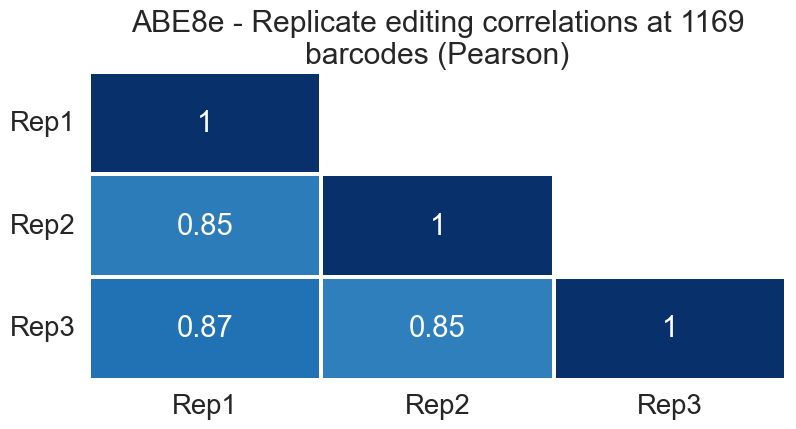

In [10]:


ABE8e_replicate_editing_df = ABE8e_combined_df.copy()
ABE8e_replicate_editing_df = ABE8e_replicate_editing_df[['ABE8e_1_totaledited','ABE8e_2_totaledited','ABE8e_3_totaledited']]

encode_df_finalABE8e = encode_df_final.dropna(subset=['ABE8e_total_edited_corrected_percentage'])
# filter ABE8e_replicate_editing_df, so that it only contains indices that are also in encode_df_finalABE8e "barcode" column.
ABE8e_replicate_editing_df = ABE8e_replicate_editing_df[ABE8e_replicate_editing_df.index.isin(encode_df_finalABE8e["barcode"])]


ABE8e_replicate_modified_df = ABE8e_combined_df.copy()
ABE8e_replicate_modified_df = ABE8e_replicate_modified_df[['ABE8e_1_modified','ABE8e_2_modified','ABE8e_3_modified']]


dataframe = ABE8e_replicate_editing_df

fig_dims = (9,4)
fig, ax = plt.subplots(figsize=fig_dims)
cmap = sn.color_palette("Blues", as_cmap=True)
corr = dataframe.corr('pearson')
x_axis_labels = ['Rep1','Rep2','Rep3']
y_axis_labels = ['Rep1','Rep2','Rep3']
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)
sn.set(font_scale = 1.8)
# sn.heatmap(corr, annot = True, fmt='.2g',vmin=0.5, vmax=1,linewidths=1.5,linecolor='white',cbar=False,cmap= cmap,mask=mask,annot_kws={"size":21}).set(title='PE2\nCorrelations')
sn.heatmap(corr, annot = True, fmt='.2g',vmin=0.5, vmax=1,linewidths=1.5,linecolor='white',cbar=False,cmap= cmap,mask=mask,annot_kws={"size":21},xticklabels=x_axis_labels, yticklabels=y_axis_labels).set(title='ABE8e - Replicate editing correlations at {}\nbarcodes (Pearson)'.format(len(dataframe)))
ax.tick_params(left=False, bottom=False)
ax.set_facecolor("white")
plt.yticks(rotation=0)
plt.show()


### Calculate editing for BE4max

--> according to 01_mapping_pipeline/src/20230415_TRIP_Editing_Analysis_BE4max.py

### Analyze editing of BE4max

In [11]:
minimumreadnumber = 100

path = './01_TRIP_pool/02_Analysis/NM_TRIP_analysis/pool/results/editing/analysis/'

def list_files_BE4max_editing(directory):
    return [f for f in listdir(directory) if "BE4max_editing_per_barcode" in f]

BE4maxfilelist = list_files_BE4max_editing(path)
# sort PEfilelist
BE4maxfilelist = sorted(BE4maxfilelist)

C_positions = [4,9,10,13,15,16,19]
combinations = []

# Generate all combinations of length 1 to 7
for i in range(1, 8):
    comb = list(itertools.combinations(C_positions, i))
    combinations.extend(comb)
combinations = [list(x) for x in combinations]

df_templist = []
suffixlist = []
alleditorslist = []

for file in BE4maxfilelist:
    df_temp = pd.read_csv(path+file)
    df_temp = df_temp.rename(columns={"Unnamed: 0":"barcode"})
    df_temp = df_temp.set_index('barcode')

    df_temp = df_temp[df_temp['barcodecount']>=minimumreadnumber]
    
    editor = file.split('_')[2]
    replicate = file.split('_')[3]
    df_temp = df_temp.add_prefix(editor+'_'+replicate+'_')
    alleditorslist.append(editor+'_'+replicate)
    print(file)
    print(editor, replicate)
    print()

    collist = [editor+'_'+replicate+'_'+str(x) for x in combinations]
    edit_collist = collist.copy()
    collist.append(editor+'_'+replicate+'_barcodecount')
    collist.append(editor+'_'+replicate+'_modified')
    collist.append(editor+'_'+replicate+'_wt')
    
    df_temp = df_temp.reindex(columns=collist, fill_value=0)
    df_temp[editor+'_'+replicate+'_totaledited'] = df_temp[edit_collist].sum(axis=1)
    df_templist.append(df_temp)
    
BE4max_combined_df = pd.concat(df_templist, axis=1)
BE4max_combined_df = BE4max_combined_df.dropna()

print('Total number of barcodes:',len(BE4max_combined_df))

20231415_TRIP-lib_BE4max_1_BE4max_editing_per_barcode.csv
BE4max 1

20231415_TRIP-lib_BE4max_2_BE4max_editing_per_barcode.csv
BE4max 2

20231415_TRIP-lib_BE4max_3_BE4max_editing_per_barcode.csv
BE4max 3

20231415_TRIP-lib_Ctrl_1_BE4max_editing_per_barcode.csv
Ctrl 1

20231415_TRIP-lib_Ctrl_2_BE4max_editing_per_barcode.csv
Ctrl 2

20231415_TRIP-lib_Ctrl_3_BE4max_editing_per_barcode.csv
Ctrl 3

Total number of barcodes: 4801


In [12]:
combinations.append('wt')
combinations.append('modified')
combinations.append('totaledited')

for edit in combinations:
    BE4max_combined_df["average_Ctrl_"+str(edit)] = BE4max_combined_df[['Ctrl_1_'+str(edit),'Ctrl_2_'+str(edit),'Ctrl_3_'+str(edit)]].mean(axis=1)

# number of barcodes before filtering
print('Total number of barcodes:',len(BE4max_combined_df))
# filter for < 5% modified or edited in control
BE4max_combined_df = BE4max_combined_df[BE4max_combined_df["average_Ctrl_modified"] < 0.05]
BE4max_combined_df = BE4max_combined_df[BE4max_combined_df["average_Ctrl_totaledited"] < 0.05]


for edit in combinations:
    edit = str(edit)
    # get average of replicates for BE4max editing/unintended editing/wt
    BE4max_combined_df["average_BE4max_"+edit] = BE4max_combined_df[['BE4max_1_'+edit,'BE4max_2_'+edit,'BE4max_3_'+edit]].mean(axis=1)

    # correct BE4max values with control values
    BE4max_combined_df['BE4max_'+edit+'_corrected'] = BE4max_combined_df.apply(lambda x: ((x['average_BE4max_'+edit]-x['average_Ctrl_'+edit])/(1-x['average_Ctrl_'+edit])),axis=1)
   
# clamp values of averageedited/indel/unedited to 0 to 1 to be consistent with prediction models
BE4max_combined_df['BE4max_totaledited_corrected'] = BE4max_combined_df['BE4max_totaledited_corrected'].clip(0,1)
BE4max_combined_df['BE4max_modified_corrected'] = BE4max_combined_df['BE4max_modified_corrected'].clip(0,1)
BE4max_combined_df['BE4max_wt_corrected'] = BE4max_combined_df.apply(lambda x: 1-x.BE4max_modified_corrected - x.BE4max_totaledited_corrected,axis=1)
  
# convert final values to percentages
BE4max_combined_df['BE4max_totaledited_corrected_percentage'] = BE4max_combined_df['BE4max_totaledited_corrected'].apply(lambda x: x*100)
BE4max_combined_df['BE4max_modified_corrected_percentage'] = BE4max_combined_df['BE4max_modified_corrected'].apply(lambda x: x*100)
BE4max_combined_df['BE4max_wt_corrected_percentage'] = BE4max_combined_df['BE4max_wt_corrected'].apply(lambda x: x*100)

# Remove row with barcode ACCTCTCCGAAATCGT, since mapping is not in one of the main chromosomes (but a variant "chr1_KI270709v1_random")
BE4max_combined_df = BE4max_combined_df[BE4max_combined_df.index != 'ACCTCTCCGAAATCGT']

# number of barcodes after filtering
print('Total number of barcodes:',len(BE4max_combined_df))


path = './01_TRIP_pool/02_Analysis/NM_TRIP_analysis/pool/results/editing/analysis/summary/'
BE4max_combined_df.to_csv(path+'20230415_TRIP_BE4max_corrected_editing_values.csv')

Total number of barcodes: 4801
Total number of barcodes: 4333


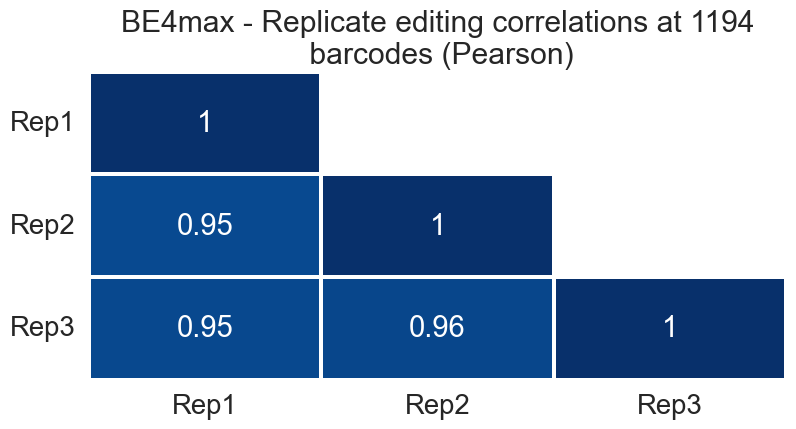

In [13]:
BE4max_replicate_editing_df = BE4max_combined_df.copy()
BE4max_replicate_editing_df = BE4max_replicate_editing_df[['BE4max_1_totaledited','BE4max_2_totaledited','BE4max_3_totaledited']]

encode_df_finalBE4max = encode_df_final.dropna(subset=['BE4max_total_edited_corrected_percentage'])
# filter ABE8e_replicate_editing_df, so that it only contains indices that are also in encode_df_finalABE8e "barcode" column.
BE4max_replicate_editing_df = BE4max_replicate_editing_df[BE4max_replicate_editing_df.index.isin(encode_df_finalBE4max["barcode"])]


BE4max_replicate_modified_df = BE4max_combined_df.copy()
BE4max_replicate_modified_df = BE4max_replicate_modified_df[['BE4max_1_modified','BE4max_2_modified','BE4max_3_modified']]


dataframe = BE4max_replicate_editing_df

fig_dims = (9,4)
fig, ax = plt.subplots(figsize=fig_dims)
cmap = sn.color_palette("Blues", as_cmap=True)
corr = dataframe.corr('pearson')
x_axis_labels = ['Rep1','Rep2','Rep3']
y_axis_labels = ['Rep1','Rep2','Rep3']
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)
sn.set(font_scale = 1.8)
# sn.heatmap(corr, annot = True, fmt='.2g',vmin=0.5, vmax=1,linewidths=1.5,linecolor='white',cbar=False,cmap= cmap,mask=mask,annot_kws={"size":21}).set(title='PE2\nCorrelations')
sn.heatmap(corr, annot = True, fmt='.2g',vmin=0.5, vmax=1,linewidths=1.5,linecolor='white',cbar=False,cmap= cmap,mask=mask,annot_kws={"size":21},xticklabels=x_axis_labels, yticklabels=y_axis_labels).set(title='BE4max - Replicate editing correlations at {}\n barcodes (Pearson)'.format(len(dataframe)))
ax.tick_params(left=False, bottom=False)
ax.set_facecolor("white")
plt.yticks(rotation=0)
plt.show()

### Calculate editing for Cas9

--> according to 01_mapping_pipeline/src/20230415_TRIP_Editing_Analysis_Cas9.py

### Analyze Cas9 editing

In [14]:
minimumreadnumber = 100

path = './01_TRIP_pool/02_Analysis/NM_TRIP_analysis/pool/results/editing/analysis/'

def list_files_Cas9_editing(directory):
    return [f for f in listdir(directory) if ("Cas9_editing_per_barcode" in f) and ("TRIP-lib" in f)]

Cas9filelist = list_files_Cas9_editing(path)
# sort PEfilelist
Cas9filelist = sorted(Cas9filelist)

df_templist = []
suffixlist = []
alleditorslist = []

for file in Cas9filelist:
    df_temp = pd.read_csv(path+file)
    df_temp = df_temp.rename(columns={"Unnamed: 0":"barcode"})
    df_temp = df_temp.set_index('barcode')

    df_temp = df_temp[df_temp['totalreads']>=minimumreadnumber]

    
    editor = file.split('_')[2]
    replicate = file.split('_')[3]
    df_temp = df_temp.add_prefix(editor+'_'+replicate+'_')
    alleditorslist.append(editor+'_'+replicate)
    print(file)
    print(editor, replicate)
    print()
    df_templist.append(df_temp)

    
Cas9_combined_df = pd.concat(df_templist, axis=1)
Cas9_combined_df = Cas9_combined_df.dropna()

Cas9_combined_df["average_Ctrl_wt"] = Cas9_combined_df[['Ctrl_1_wt_percentage','Ctrl_2_wt_percentage','Ctrl_3_wt_percentage']].mean(axis=1)
Cas9_combined_df["average_Ctrl_modified"] = Cas9_combined_df[['Ctrl_1_modified_percentage','Ctrl_2_modified_percentage','Ctrl_3_modified_percentage']].mean(axis=1)

# number of barcodes before filtering
print('Total number of barcodes:',len(Cas9_combined_df))

# filter for < 5% unintended editing in control
Cas9_combined_df = Cas9_combined_df[Cas9_combined_df["average_Ctrl_modified"] < 0.05]


# get average of replicates for Cas9 editing/unintended editing/wt
Cas9_combined_df["average_Cas9_wt"] = Cas9_combined_df[['Cas9_1_wt_percentage','Cas9_2_wt_percentage','Cas9_3_wt_percentage']].mean(axis=1)
Cas9_combined_df["average_Cas9_modified"] = Cas9_combined_df[['Cas9_1_modified_percentage','Cas9_2_modified_percentage','Cas9_3_modified_percentage']].mean(axis=1)

# correct Cas9 values with control values
Cas9_combined_df['Cas9_modified_corrected'] = Cas9_combined_df.apply(lambda x: ((x['average_Cas9_modified']-x['average_Ctrl_modified'])/(1-x['average_Ctrl_modified'])),axis=1)

# clamp values of to 0 to 1 to be consistent with prediction models
Cas9_combined_df['Cas9_modified_corrected'] = Cas9_combined_df['Cas9_modified_corrected'].clip(0,1)
Cas9_combined_df['Cas9_wt_corrected'] = Cas9_combined_df.apply(lambda x: 1-x.Cas9_modified_corrected,axis=1)

# convert final values to Cas9rcentages
Cas9_combined_df['Cas9_modified_corrected_percentage'] = Cas9_combined_df['Cas9_modified_corrected'].apply(lambda x: x*100)
Cas9_combined_df['Cas9_wt_corrected_percentage'] = Cas9_combined_df['Cas9_wt_corrected'].apply(lambda x: x*100)
    

Cas9_combined_df = Cas9_combined_df.dropna()

# Remove row with barcode ACCTCTCCGAAATCGT, since mapping is not in one of the main chromosomes (but a variant "chr1_KI270709v1_random")
Cas9_combined_df = Cas9_combined_df[Cas9_combined_df.index != 'ACCTCTCCGAAATCGT']


path = './01_TRIP_pool/02_Analysis/NM_TRIP_analysis/pool/results/editing/analysis/summary/'
Cas9_combined_df.to_csv(path+'20230415_TRIP_Cas9_corrected_editing_values.csv')


# number of barcodes after filtering
print('Total number of barcodes after filtering:',len(Cas9_combined_df))



20231415_TRIP-lib_Cas9_1_Cas9_editing_per_barcode.csv
Cas9 1

20231415_TRIP-lib_Cas9_2_Cas9_editing_per_barcode.csv
Cas9 2

20231415_TRIP-lib_Cas9_3_Cas9_editing_per_barcode.csv
Cas9 3

20231415_TRIP-lib_Ctrl_1_Cas9_editing_per_barcode.csv
Ctrl 1

20231415_TRIP-lib_Ctrl_2_Cas9_editing_per_barcode.csv
Ctrl 2

20231415_TRIP-lib_Ctrl_3_Cas9_editing_per_barcode.csv
Ctrl 3

Total number of barcodes: 5073
Total number of barcodes after filtering: 4522


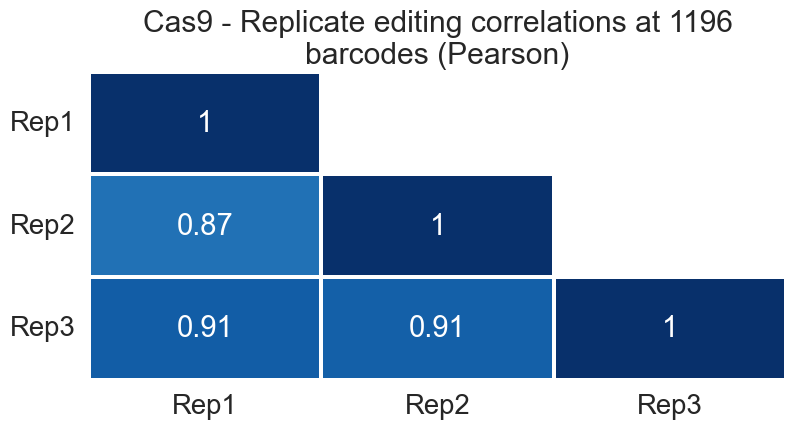

In [15]:
Cas9_replicate_modified_df = Cas9_combined_df.copy()
Cas9_replicate_modified_df = Cas9_replicate_modified_df[['Cas9_1_modified_percentage','Cas9_2_modified_percentage','Cas9_3_modified_percentage']]

encode_df_finalCas9 = encode_df_final.dropna(subset=['Cas9_modified_corrected_percentage'])
# filter Cas9_replicate_editing_df, so that it only contains indices that are also in encode_df_finalCas9 "barcode" column.
Cas9_replicate_modified_df = Cas9_replicate_modified_df[Cas9_replicate_modified_df.index.isin(encode_df_finalCas9["barcode"])]

dataframe = Cas9_replicate_modified_df

fig_dims = (9,4)
fig, ax = plt.subplots(figsize=fig_dims)
cmap = sn.color_palette("Blues", as_cmap=True)
corr = dataframe.corr('pearson')
x_axis_labels = ['Rep1','Rep2','Rep3']
y_axis_labels = ['Rep1','Rep2','Rep3']
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)
sn.set(font_scale = 1.8)
# sn.heatmap(corr, annot = True, fmt='.2g',vmin=0.5, vmax=1,linewidths=1.5,linecolor='white',cbar=False,cmap= cmap,mask=mask,annot_kws={"size":21}).set(title='PE2\nCorrelations')
sn.heatmap(corr, annot = True, fmt='.2g',vmin=0.5, vmax=1,linewidths=1.5,linecolor='white',cbar=False,cmap= cmap,mask=mask,annot_kws={"size":21},xticklabels=x_axis_labels, yticklabels=y_axis_labels).set(title='Cas9 - Replicate editing correlations at {}\nbarcodes (Pearson)'.format(len(dataframe)))
ax.tick_params(left=False, bottom=False)
ax.set_facecolor("white")
plt.yticks(rotation=0)
plt.show()

In [16]:
alleditordf = ABE8e_combined_df.copy()
alleditordf['PE_edited_corrected_percentage'] = PE_combined_df['PE_edited_corrected_percentage']
alleditordf['PE_unintended_editing_corrected_percentage'] = PE_combined_df['PE_unintended_editing_corrected_percentage']
alleditordf['BE4max_totaledited_corrected_percentage'] = BE4max_combined_df['BE4max_totaledited_corrected_percentage']
alleditordf['BE4max_modified_corrected_percentage'] = BE4max_combined_df['BE4max_modified_corrected_percentage']
alleditordf['Cas9_modified_corrected_percentage'] = Cas9_combined_df['Cas9_modified_corrected_percentage']

cols = ['ABE8e_totaledited_corrected_percentage',
       'ABE8e_modified_corrected_percentage',
       'PE_edited_corrected_percentage',
       'PE_unintended_editing_corrected_percentage',
       'BE4max_totaledited_corrected_percentage',
       'BE4max_modified_corrected_percentage',
       'Cas9_modified_corrected_percentage']
alleditordf = alleditordf[cols]
alleditordf.corr('spearman')

# print number of total barcodes with editing
print('Total number of barcodes:',len(alleditordf))

# filter out barcodes with no editing in one of the editors
alleditordf = alleditordf.dropna()
path = './01_TRIP_pool/02_Analysis/NM_TRIP_analysis/pool/results/editing/analysis/summary/'
alleditordf.to_csv(path+'20230415_TRIP_alleditors_filtered_corrected_editing_values.csv')

# print number of total barcodes with editing in all editors
print('Total number of barcodes:',len(alleditordf))


Total number of barcodes: 4110
Total number of barcodes: 4000


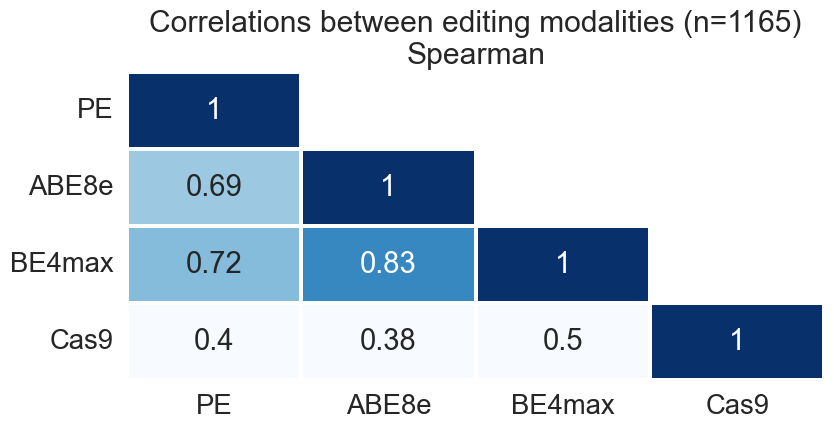

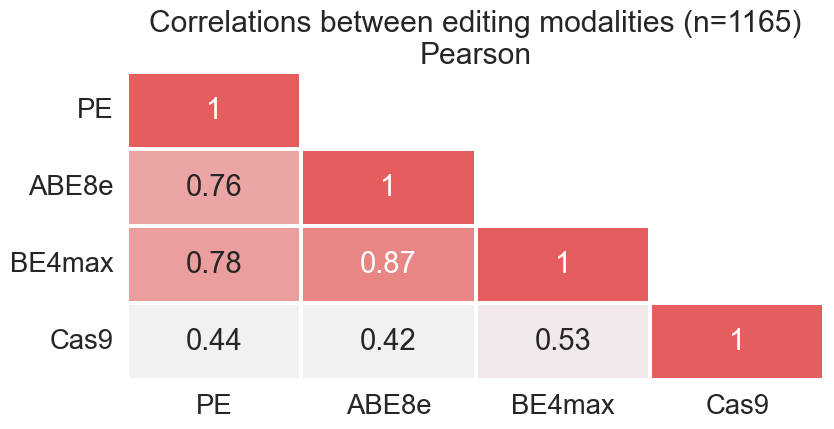

In [17]:
relevant_cols = ['PE_edited_corrected_percentage','ABE8e_totaledited_corrected_percentage','BE4max_totaledited_corrected_percentage','Cas9_modified_corrected_percentage']

comparison_editing_rates_editors = alleditordf[relevant_cols].copy()

editingcollist = ['PE_edited_corrected_percentage', 'ABE8e_total_edited_corrected_percentage', 'BE4max_total_edited_corrected_percentage', 'Cas9_modified_corrected_percentage']
encode_df_finalAll = encode_df_final.dropna(subset=editingcollist).copy()
comparison_editing_rates_editors = comparison_editing_rates_editors[comparison_editing_rates_editors.index.isin(encode_df_finalAll["barcode"])]


dataframe = comparison_editing_rates_editors

labels = {
    'PE_edited_corrected_percentage': 'PE', 
    'ABE8e_totaledited_corrected_percentage': 'ABE8e', 
    'BE4max_totaledited_corrected_percentage': 'BE4max', 
    'Cas9_modified_corrected_percentage': 'Cas9'
}

dataframe.rename(columns=labels, inplace=True)

# Compute correlations
corr_spearman = dataframe.corr('spearman')
corr_pearson = dataframe.corr('pearson')

# Define the size of the figures
fig_dims = (9,4)

# Plot heatmap for Spearman
fig, ax = plt.subplots(figsize=fig_dims)
cmap = sn.color_palette("Blues", as_cmap=True)
mask = np.triu(np.ones_like(corr_spearman, dtype=bool))
np.fill_diagonal(mask, False)
sn.set(font_scale = 1.8)
sn.heatmap(corr_spearman, annot = True, fmt='.2g', vmin=0.5, vmax=1, linewidths=1.5, linecolor='white', cbar=False, cmap= cmap, mask=mask, annot_kws={"size":21}).set(title=f'Correlations between editing modalities (n={len(dataframe)})\nSpearman')
ax.tick_params(left=False, bottom=False)
ax.set_facecolor("white")
plt.yticks(rotation=0)
plt.show()

# Plot heatmap for Pearson
fig, ax = plt.subplots(figsize=fig_dims)
# Create a custom color palette that transitions to #E45E5E
cmap = sns.light_palette("#E45E5E", as_cmap=True)

mask = np.triu(np.ones_like(corr_pearson, dtype=bool))
np.fill_diagonal(mask, False)
sn.set(font_scale = 1.8)
sn.heatmap(corr_pearson, annot = True, fmt='.2g', vmin=0.5, vmax=1, linewidths=1.5, linecolor='white', cbar=False, cmap= cmap, mask=mask, annot_kws={"size":21}).set(title=f'Correlations between editing modalities (n={len(dataframe)})\nPearson')
ax.tick_params(left=False, bottom=False)
ax.set_facecolor("white")
plt.yticks(rotation=0)
plt.show()


In [18]:
def correlation_plot(x, y,xlabel,ylabel, title, trendline=False, max_x=100, max_y=100):
        x = np.array(x)
        y = np.array(y)
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        Correlation_x, Correlation_y, Correlation_z = x[idx], y[idx], z[idx]

        # Sort the points by density, so that the densest points are plotted last
        R = stats.spearmanr(x, y)[0]
        r = stats.pearsonr(x, y)[0]

        fig, ax = plt.subplots(figsize = (5, 5),dpi=150)
        ax.scatter(Correlation_x, Correlation_y, c=Correlation_z, s=0.3)
        xlabels=[0,20,40,60,80,100]
        ax.tick_params(axis='x', labelsize= 16, width=1.5)
        ax.tick_params(axis='y', labelsize= 16, width=1.5)
        ax.set_xlabel(xlabel, fontsize=16)
        ax.set_ylabel(ylabel, fontsize=16)
        ax.set_xlim(0, max_x)
        ax.set_ylim(0, max_y)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.text(0.05, 0.95, 'R = '+str(round(R, 2))+'\nr = '+str(round(r, 2)), transform=ax.transAxes, fontsize=16,
                verticalalignment='top')
        ax.set_title(title, fontsize=titlesize)
        if trendline == True:
                z = np.polyfit(x, y, 1)
                p = np.poly1d(z)
                # Set trendline color to gray, use '.' linestyle for dots, and set linewidth to a smaller value
                plt.plot(x, p(x), linestyle=':', color='gray', linewidth=1)
        
        plt.show()
plt.rcdefaults()

# for y in ['Cas9','ABE8e','BE4max']:
#         x = 'PE'
#         correlation_plot(comparison_editing_rates_editors[x], comparison_editing_rates_editors[y],x+ ' editing efficiency (%)',y+ ' editing efficiency (%)', x+' vs. '+y, trendline=False, max_x=100, max_y=100)


### Combine editing with mappings

In [19]:
# import library mapping table
path = './01_TRIP_pool/02_Analysis/NM_TRIP_analysis/pool/results/mapping/'
libmappingdf = pd.read_csv(path+'20230409_NM-TRIP_Library_hg38_Library_finalmapping_mappings_with_barcodes.csv')
libmappingdf = libmappingdf.set_index('barcode')

# only keep mappings where the fw and rv alignments are 4bp apart from each other (TTAA motif), described in the "1_distance_for_rev" column
libmappingdf = libmappingdf[libmappingdf['1_distance_for_rev'] == 4]
cols = ['1_chromosome','1_center_position']
libmappingdf = libmappingdf[cols]
# rename columns in library mapping dataframe to chromosome and position
libmappingdf.columns = ['chromosome','position']
# make position column to an integer
libmappingdf['position'] = libmappingdf['position'].astype(int)


# for each editor, make a new dataframe with the library mapping table and the respective rows with overlapping barcodes
# PE
PE_edited_mappingdf = pd.merge(PE_combined_df, libmappingdf, left_on='barcode', right_index=True)
PE_edited_mappingdf.to_csv(path+'20230416_PE_edited_mapped_summary.csv')

# ABE8e
ABE8e_totaledited_mappingdf = pd.merge(ABE8e_combined_df, libmappingdf, left_on='barcode', right_index=True)
ABE8e_totaledited_mappingdf.to_csv(path+'20230416_ABE8e_totaledited_mapped_summary.csv')

# BE4max
BE4max_totaledited_mappingdf = pd.merge(BE4max_combined_df, libmappingdf, left_on='barcode', right_index=True)
BE4max_totaledited_mappingdf.to_csv(path+'20230416_BE4max_totaledited_mapped_summary.csv')

# Cas9
Cas9_modified_mappingdf = pd.merge(Cas9_combined_df, libmappingdf, left_on='barcode', right_index=True)
Cas9_modified_mappingdf.to_csv(path+'20230416_Cas9_modified_mapped_summary.csv')

# make a new dataframe with all the editors
alleditor_edited_mappingdf = pd.concat([PE_edited_mappingdf, ABE8e_totaledited_mappingdf, BE4max_totaledited_mappingdf, Cas9_modified_mappingdf], axis=1)
# only keep chromosome, position, editing and modified/unintended editing columns
alleditor_edited_mappingdf = alleditor_edited_mappingdf[['PE_edited_corrected_percentage','PE_unintended_editing_corrected_percentage',
                                                         'ABE8e_totaledited_corrected_percentage','ABE8e_modified_corrected_percentage',
                                                         'BE4max_totaledited_corrected_percentage','BE4max_modified_corrected_percentage',
                                                         'Cas9_modified_corrected_percentage']]


# add columns chromosome and position from the libmappingdf to the alleditor_edited_mappingdf and put them to the front of the dataframe
alleditor_edited_mappingdf['chromosome'] = libmappingdf['chromosome']
alleditor_edited_mappingdf['position'] = libmappingdf['position']
alleditor_edited_mappingdf = alleditor_edited_mappingdf[['chromosome','position','PE_edited_corrected_percentage','PE_unintended_editing_corrected_percentage',
                                                         'ABE8e_totaledited_corrected_percentage','ABE8e_modified_corrected_percentage',
                                                         'BE4max_totaledited_corrected_percentage','BE4max_modified_corrected_percentage',
                                                         'Cas9_modified_corrected_percentage']]   

# make position column to an integer
alleditor_edited_mappingdf['position'] = alleditor_edited_mappingdf['position'].astype(int)

alleditor_edited_mappingdf.to_csv(path+'20230416_alleditor_edited_mapped_summary.csv')

# print length of the differen dataframes (with "Length of" + the name of the dataframe)
print('Length of PE_edited_mappingdf: {}'.format(len(PE_edited_mappingdf)))
print('Length of ABE8e_totaledited_mappingdf: {}'.format(len(ABE8e_totaledited_mappingdf)))
print('Length of BE4max_totaledited_mappingdf: {}'.format(len(BE4max_totaledited_mappingdf)))
print('Length of Cas9_modified_mappingdf: {}'.format(len(Cas9_modified_mappingdf)))
print('Length of alleditor_edited_mappingdf (including NaNs): {}'.format(len(alleditor_edited_mappingdf)))

Length of PE_edited_mappingdf: 1182
Length of ABE8e_totaledited_mappingdf: 1169
Length of BE4max_totaledited_mappingdf: 1194
Length of Cas9_modified_mappingdf: 1196
Length of alleditor_edited_mappingdf (including NaNs): 1202


### Visualization of mappings

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def chromosome_editing_location_plot(path, filename, plottitle, chromlengthdf):
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams['axes.linewidth'] = axesthickness
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['font.family'] = 'Arial'

    print('Plotting',plottitle,'editings at different positions on the chromosomes')
    df = pd.read_csv(path+filename)
    

    chromosomes = [f"chr{i}" for i in range(1, 23)] + ["chrX"]
    df = df[df['chromosome'].isin(chromosomes)]
    print('Total mappings:',len(df))

    fig, ax = plt.subplots(figsize=(6,6),dpi=150)
    ax.set_xlim([-2000000, 255000000])
    plt.xticks(ticks=[0, 50e6, 100e6, 150e6, 200e6, 250e6], labels=[0, 50, 100, 150, 200, 250])
    ax.set_ylim([len(chromosomes)+1, 0])

    for chrom in chromosomes:
        chromosome_length = chromlengthdf.loc[chrom, 'length']
        centromere_position = chromlengthdf.loc[chrom, 'centromer_position']
        i = chromosomes.index(chrom) + 1
        chrom_patch = patches.FancyBboxPatch((0, i + -1/4), chromosome_length, 4/10, boxstyle="round,pad=0.02", facecolor='#F2F2F2', edgecolor='#F2F2F2', linewidth=1.5)
        ax.add_patch(chrom_patch)
        chrom_patch.set_boxstyle("round,pad=0.02, rounding_size=0.5")


    for i, chrom in enumerate(chromosomes):
        temp_df = df[df["chromosome"] == chrom]
        positions = temp_df["position"]
        if chrom == 'chr1':
            print(max(positions))
        for pos in positions:
            ax.vlines(pos, i + 2/8+ 0.38, i + 6/8+0.38, colors='#696969', linewidth=1.5)

    ax.set_yticks(range(1, len(chromosomes)+1))
    ax.set_yticklabels(chromosomes)

    # Adjust tick label font sizes
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=12) 

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel("Position on chromosome (x10E6)", fontsize=14)
    ax.set_ylabel("Chromosome", fontsize=14)
    ax.set_title("Insertion locations overview (K562)\n"+plottitle, fontsize=16)

    plt.show()


In [21]:
#cytobanddf downloaded from UCSC via http://hgdownload.cse.ucsc.edu/goldenPath/hg38/database/cytoBand.txt.gz
cytobanddf = pd.read_csv('cytoBand.txt', sep='\t', header=None)
cytobanddf = cytobanddf[cytobanddf[4] == 'acen']
# drop every second row
cytobanddf = cytobanddf.iloc[::2]
cytobanddf = cytobanddf.set_index(0, drop=True)
cytobanddf['centromer_position'] = cytobanddf[2]
cytobanddf = cytobanddf[['centromer_position']]

chromlengthdf = pd.read_csv('20230713_chromosome_lengths.csv')
chromlengthdf['chromosome'] = chromlengthdf['chromosome'].apply(lambda x: "chr" + str(x))
chromlengthdf = chromlengthdf.set_index('chromosome')
chromlengthdf['centromer_position'] = cytobanddf['centromer_position']
chromlengthdf

,length,centromer_position
chromosome,,
chr1,248956422,123400000
chr2,242193529,93900000
chr3,198295559,90900000
chr4,190214555,50000000
chr5,181538259,48800000
chr6,170805979,59800000
chr7,159345973,60100000
chr8,145138636,45200000
chr9,138394717,43000000


Plotting PE editings at different positions on the chromosomes
Total mappings: 1182


248924506


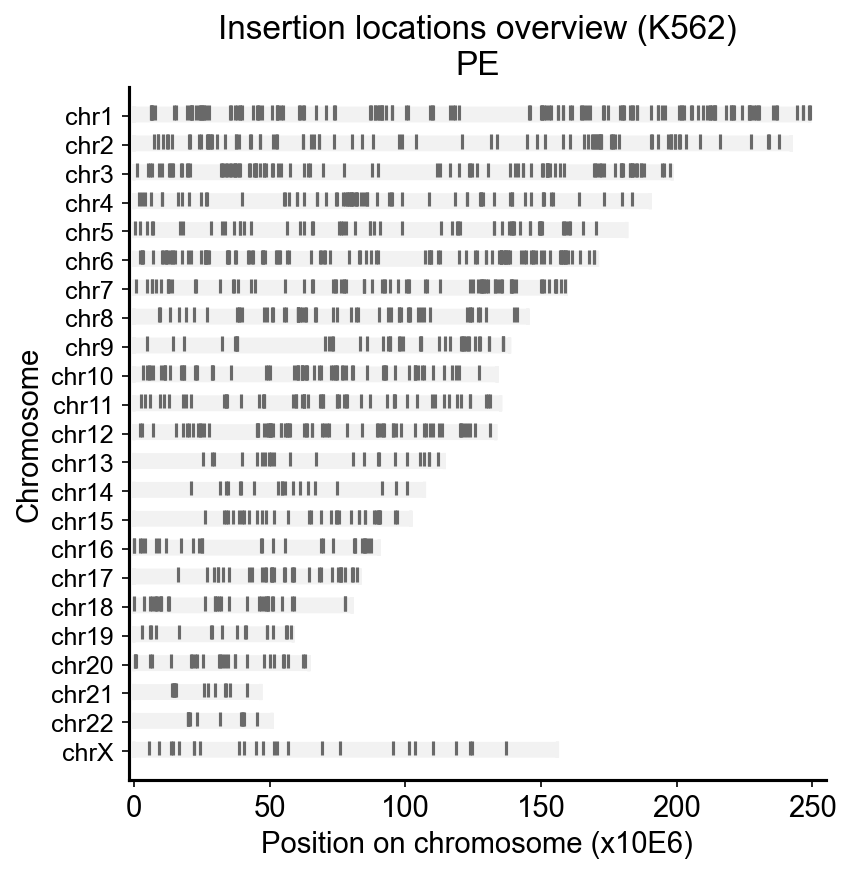

In [22]:
path = './01_TRIP_pool/02_Analysis/NM_TRIP_analysis/pool/results/mapping/'

filename = '20230416_PE_edited_mapped_summary.csv'
editcolumn = 'PE_edited_corrected_percentage'
editname = 'Editing efficiency (%)'
plottitle = 'PE'
chromosome_editing_location_plot(path, filename, plottitle, chromlengthdf)

### PE Chromatin feature analysis - import chromatin characteristics

In [25]:
path = './01_TRIP_pool/02_Analysis/NM_TRIP_analysis/pool/results/mapping/'

filename = '20230416_alleditor_edited_mapped_summary.csv'
df = pd.read_csv(path+filename)
df = df.set_index('barcode')


path = "./01_TRIP_pool/02_Analysis/Chromatin_Marks/results/"
encode_df = pd.read_csv(path+"20230410_barcodes_with_chromatinfeatures_Library.csv")
encode_df = encode_df.set_index('barcode')
# add the editing percentages to the encode_df
encode_df['PE_edited_corrected_percentage'] = df['PE_edited_corrected_percentage']
encode_df['PE_unintended_editing_corrected_percentage'] = df['PE_unintended_editing_corrected_percentage']
encode_df['ABE8e_total_edited_corrected_percentage'] = df['ABE8e_totaledited_corrected_percentage']
encode_df['BE4max_total_edited_corrected_percentage'] = df['BE4max_totaledited_corrected_percentage']
encode_df['Cas9_modified_corrected_percentage'] = df['Cas9_modified_corrected_percentage']


# get all these editing columns into one list called "editingcollist"
editingcollist = ['PE_edited_corrected_percentage', 'PE_unintended_editing_corrected_percentage', 'ABE8e_total_edited_corrected_percentage', 'BE4max_total_edited_corrected_percentage', 'Cas9_modified_corrected_percentage']



path = "./01_TRIP_pool/02_Analysis/Chromatin_Marks/"
encode_details = pd.read_csv(path+"20230324_ENCODE_Selected_Datasets_Overview.csv")

# Combine the encode number in the column titles with the target label (e.g. "H3K4me3" etc.) for better readability:
    # for each column in encode_df, check if any of the cells in the column 'Title' of the encode_details dataframe occur
    # if yes, add the name of the respecitve row in the column "Target label" to the columntitle in encode_df with an underscore (e.g. *title*_XYZ)
    # it will replace the name of the old column name

# Create a dictionary to store the new column names
column_mapping = {}

# Iterate through the columns in encode_df
for column in encode_df.columns:
    # Iterate through the rows in encode_details
    for index, row in encode_details.iterrows():
        title = row['Title']
        target_label = row['Target label']
        assay_name = row['Assay term name']
        
        if assay_name == 'ATAC-seq':  # Add ATAC-seq to the column name if it is ATAC-seq (not Target label)
            target_label = row['Assay term name']
        
        if title in column:
            #print(title)
            #print(target_label)
            new_column_name = target_label + '_' + column
            column_mapping[column] = new_column_name
            break

# Rename columns using the column_mapping dictionary
encode_df = encode_df.rename(columns=column_mapping)

suppl_encode_df = encode_df.copy()
encode_df = encode_df.drop(['chromosome', 'position'], axis=1)



In [26]:
suppl_encode_df.drop('PE_unintended_editing_corrected_percentage', axis=1, inplace=True)

# 2. Rename the columns
new_column_names = {
    'PE_edited_corrected_percentage': 'PE_editing_efficiency',
    'ABE8e_total_edited_corrected_percentage': 'ABE8e_editing_efficiency',
    'BE4max_total_edited_corrected_percentage': 'BE4max_editing_efficiency',
    'Cas9_modified_corrected_percentage': 'Cas9_editing_efficiency'
}

suppl_encode_df.rename(columns=new_column_names, inplace=True)

# 3. Reorder columns
other_columns = [col for col in suppl_encode_df.columns if col not in ['chromosome', 'position'] and col not in new_column_names.values()]
new_column_order = ['chromosome', 'position'] + list(new_column_names.values()) + other_columns

suppl_encode_df = suppl_encode_df[new_column_order]

# Drop rows where all values in the specified columns are NaN
columns_to_check = ['PE_editing_efficiency', 'ABE8e_editing_efficiency', 'BE4max_editing_efficiency', 'Cas9_editing_efficiency']
suppl_encode_df.dropna(subset=columns_to_check, how='all', inplace=True)
suppl_encode_df.to_csv('20230921_trip_library_supplementary_table.csv')

In [27]:
# make subsets of the dataframe for different sets of chromatin marks:

lietal_featurelist = ["Dnase-seq","H3K79me2","CTCF",
                      "POLR2A","ATAC","H3K9ac","H3K9me3",
                      "H3K9me1","H4K20me1","BRD4","EZH2",
                      "H2AFZ","POLR2AS2","SMC3","HDAC1",
                      "HDAC2","HDAC3","H3K4me3","H3K4me2",
                      "H3K4me1","H3K27me3","H3K27ac","H3K36me3"]

# make new dataframe "encode_df_lionly" and only keep the columns which contain one of the strings in the list "lietal_featurelist" within the columnname itself. Additionally keep the column "PE_edited_corrected_percentage".
encode_df_lionly = encode_df[[column for column in encode_df.columns if any(feature in column for feature in lietal_featurelist)]+editingcollist]

1182


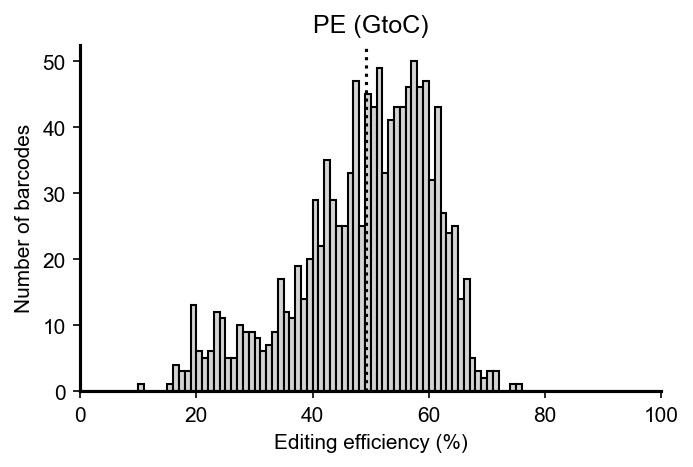

1169


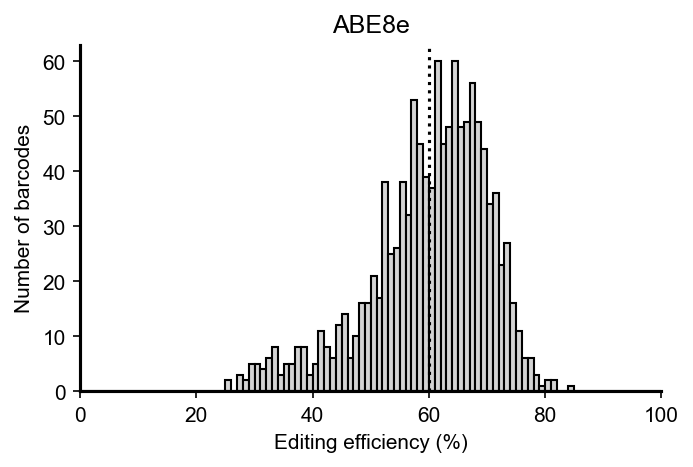

1194


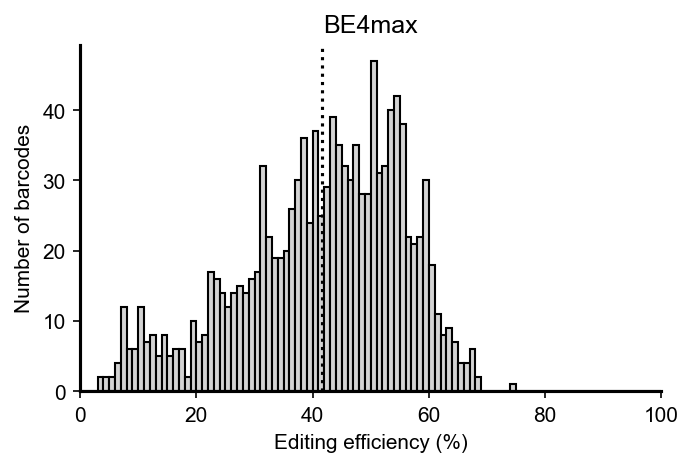

1196


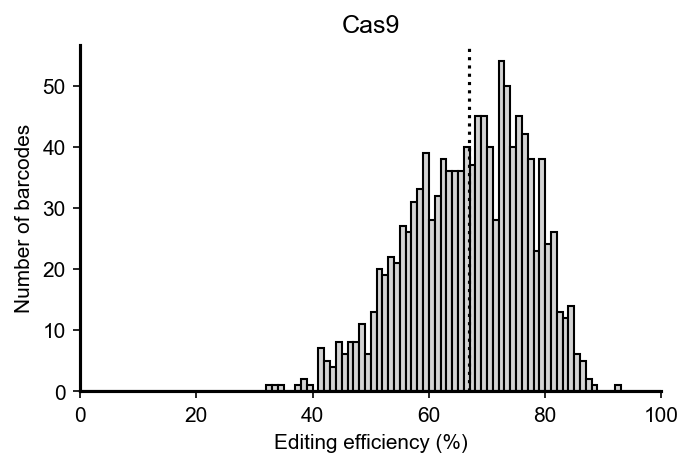

In [28]:
# List of columns and their corresponding names
columns = ['PE_edited_corrected_percentage',
           'ABE8e_totaledited_corrected_percentage',
           'BE4max_totaledited_corrected_percentage',
           'Cas9_modified_corrected_percentage']

names = ['PE (GtoC)', 'ABE8e','BE4max','Cas9']

# Iterate over the list of columns
for column, name in zip(columns, names):

    fig, ax = plt.subplots(figsize = (5, 3),dpi=150)
    # Plot histogram for each column
    ax.hist(df[column], bins=100, range=(0,100), color='lightgrey', edgecolor='black', linewidth=1)
    print(len(df[column].dropna()))
    # Add a vertical dotted line at the mean
    ax.axvline(df[column].mean(), color='black', linestyle='dotted')

    # Set the x-axis label
    # plt.xlabel(name + ' Editing efficiency (%)')
    ax.set_xlabel('Editing efficiency (%)')

    # Set the y-axis label
    ax.set_ylabel('Number of barcodes')
    # Set the title of the plot
    # plt.title(name + ' - Editing efficiency distribution')

    ax.set_title(name)

    ax.set_xlim(0, 100)

    # Remove the top and right edges of the plot
    sns.despine()
    # Show the plot
    plt.show()

#### UMAP of encode_df

1165
1165


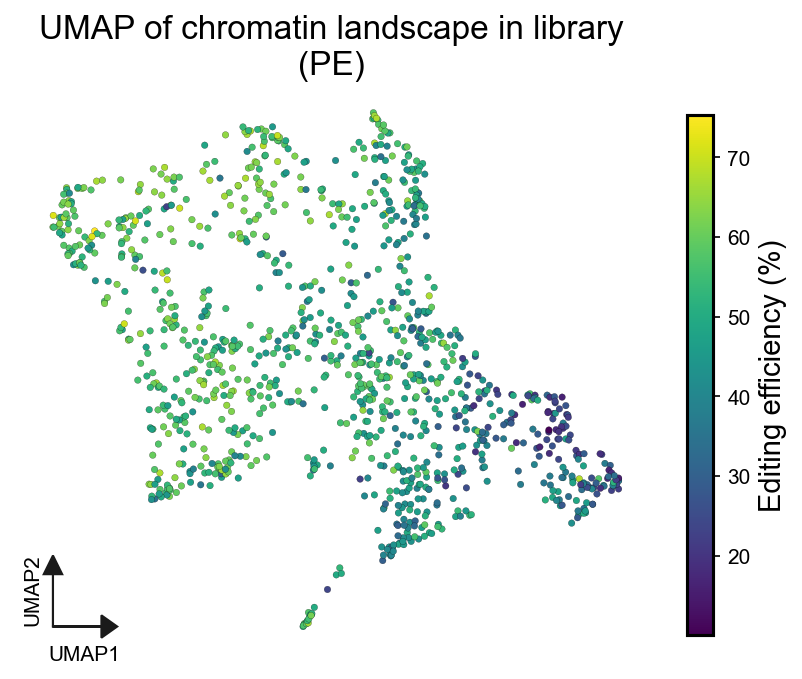

1165


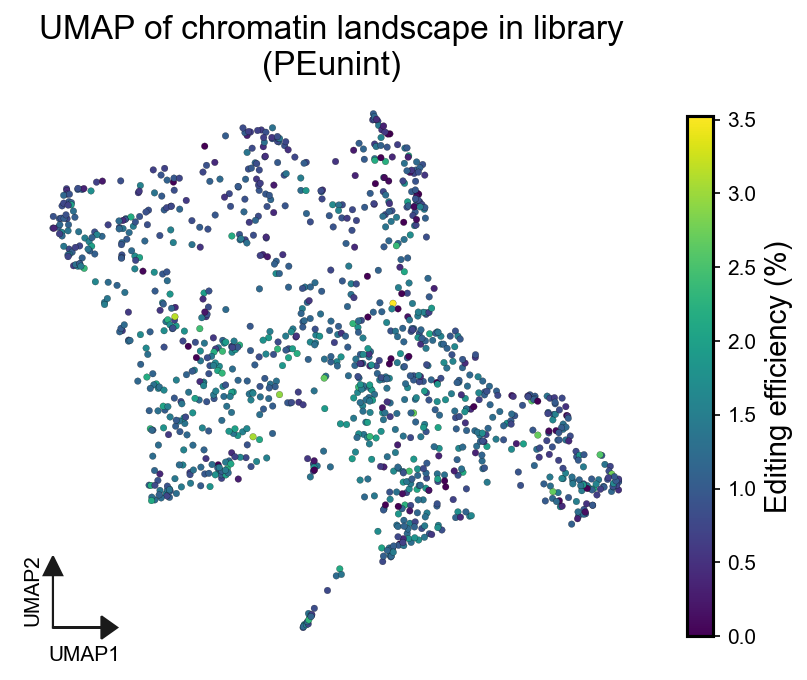

1165


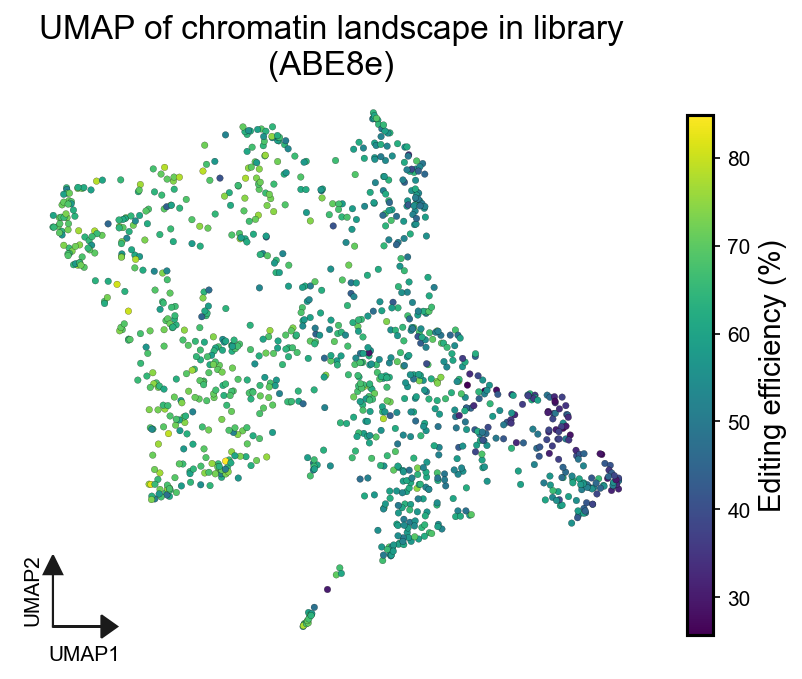

1165


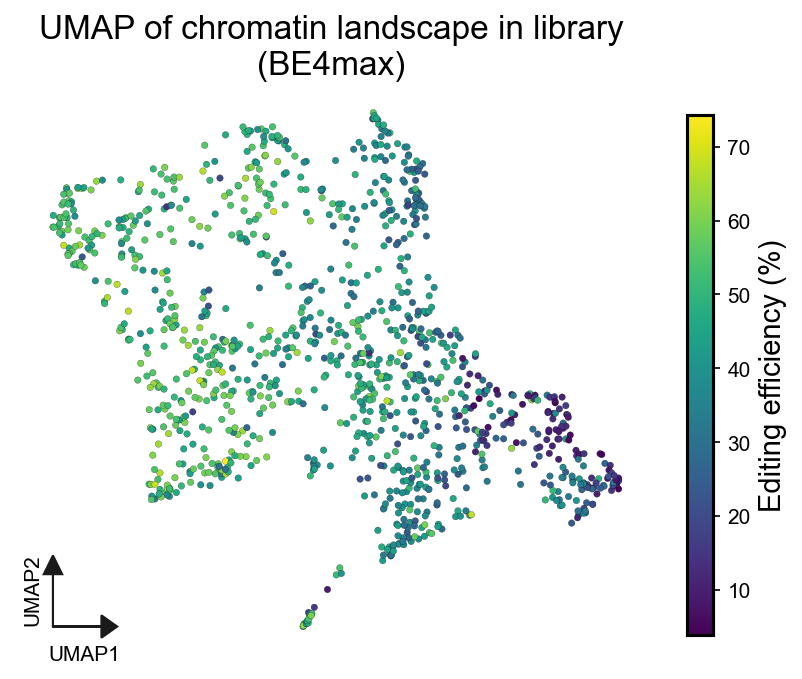

1165


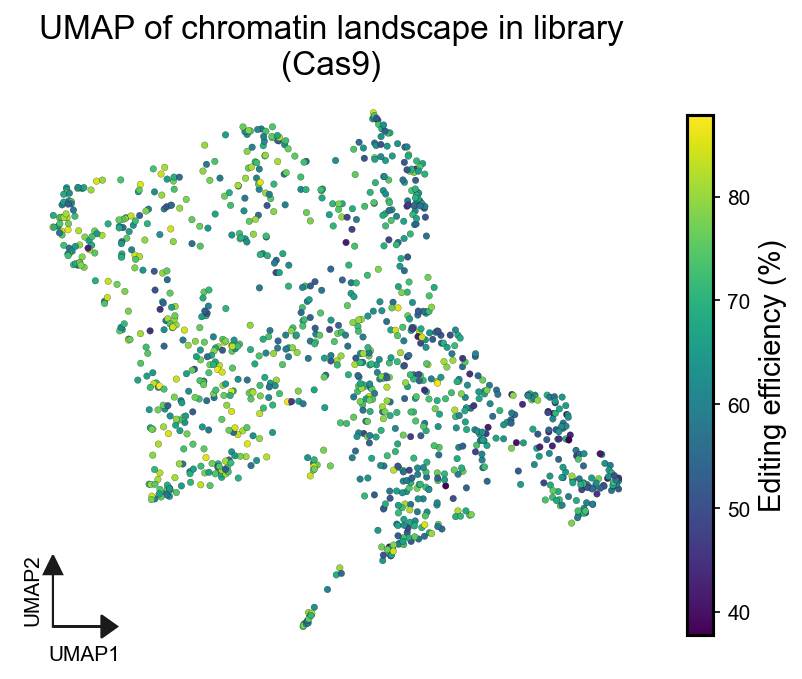

In [29]:
# Define your color columns
color_columns = ['PE_edited_corrected_percentage',
                 'PE_unintended_editing_corrected_percentage',
                 'ABE8e_total_edited_corrected_percentage',
                 'BE4max_total_edited_corrected_percentage',
                 'Cas9_modified_corrected_percentage']

title_columns = ['PE', 'PEunint','ABE8e','BE4max','Cas9']

# Create your features list by excluding the color columns
features = [col for col in encode_df.columns if col not in color_columns]

# Combine both feature and color columns
all_columns = features + color_columns

# Create a sub DataFrame with all relevant columns and drop rows with any NaN values
sub_encode_df = encode_df[all_columns].dropna()
print(len(sub_encode_df))

# Perform UMAP
reducer = umap.UMAP(random_state=2)
embedding = reducer.fit_transform(sub_encode_df[features])

# For each color_column, create a UMAP plot
for index, color in enumerate(color_columns):
    fig, ax = plt.subplots(figsize=(6.8,5), dpi=150)
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=sub_encode_df[color], cmap='viridis', s=10, edgecolor='black', linewidths=0.1) 
    print(len(embedding[:, 0]))
    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.9)
    cbar.set_label('Editing efficiency (%)', fontsize=14)

    # Hide all spines and tick marks
    ax.axis('off')

    # Determine the starting point for arrows based on the minimum values of the data
    start_x, start_y = np.min(embedding[:, 0]), np.min(embedding[:, 1])

    # Length of arrows (arbitrary, you can set as you like)
    arrow_length = 1

    # Draw arrows
    ax.arrow(start_x, start_y, arrow_length-0.08, 0, head_width=0.3, head_length=0.3, fc='k', ec='k')
    ax.arrow(start_x, start_y, 0, arrow_length-0.3, head_width=0.35, head_length=0.25, fc='k', ec='k')

    # Label arrows
    ax.text(start_x + arrow_length-0.4, start_y-0.5, 'UMAP1', fontsize=10, ha='center', va='bottom')
    ax.text(start_x-0.2, start_y-0.5 + arrow_length, 'UMAP2', fontsize=10, ha='right', va='center', rotation='vertical')

    ax.set_title(f'UMAP of chromatin landscape in library\n({title_columns[index]})', fontsize=16)  # Title
    
    plt.show()

c:\Users\nicol\anaconda3\envs\chromatin\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


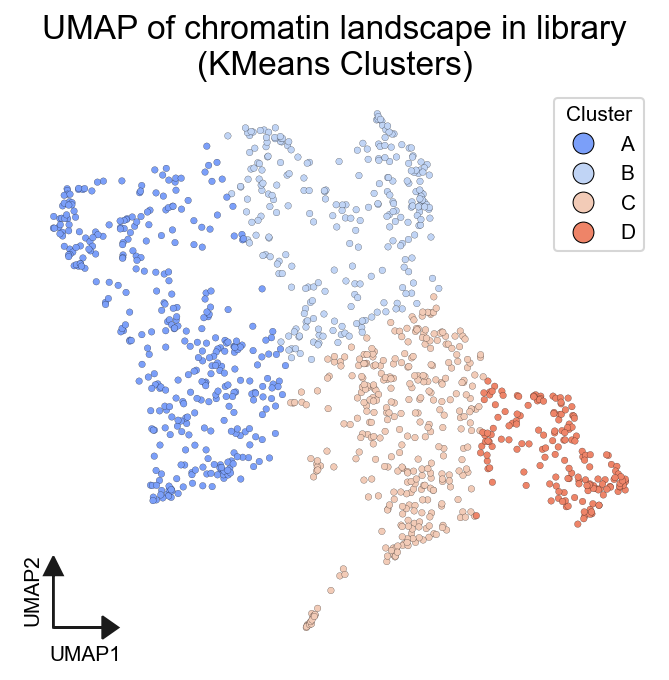

In [30]:
# Define the number of clusters you want
n_clusters = 4

letter_labels = ['A', 'B', 'C', 'D']

# Create a KMeans instance
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)

# Fit the KMeans model and predict the cluster assignments for each data point
cluster_assignments = kmeans.fit_predict(embedding)

# Add the cluster assignments to your DataFrame
sub_encode_df['cluster'] = cluster_assignments

sub_encode_df['x_coord'] = embedding[:, 0]

# Calculate the mean x-coordinate of each cluster
cluster_means = sub_encode_df.groupby('cluster')['x_coord'].mean().sort_values()

# Create a dictionary mapping the old cluster labels to the new ones
new_cluster_labels = {old: new for new, old in enumerate(cluster_means.index)}

# Replace the old cluster labels with the new ones
sub_encode_df['cluster'] = sub_encode_df['cluster'].replace(new_cluster_labels)


# Create a mapping dictionary from cluster number to alphabet
cluster_to_alpha = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}


# Replace cluster numbers with alphabets in sub_encode_df
sub_encode_df['cluster'] = sub_encode_df['cluster'].replace(cluster_to_alpha)

# Extract 5 distinct colors from the 'coolwarm' palette
palette_colors = sns.color_palette('coolwarm', 4)

# Create a mapping from cluster label to color
label_to_color = {label: color for label, color in zip(letter_labels, palette_colors)}

# Create a subplot to better control the plot
fig, ax = plt.subplots(figsize=(5.5, 5), dpi=150)

# Create the scatter plot with cluster colors
scatter_plot = ax.scatter(embedding[:, 0], embedding[:, 1], c=sub_encode_df['cluster'].map(label_to_color), edgecolors='black', linewidths=0.1, s=10)

# Create custom legend
legend_labels = [plt.Line2D([0], [0], linestyle='none', marker='o', markersize=10, markerfacecolor=label_to_color[label], markeredgecolor='black', markeredgewidth=0.5) for label in letter_labels]
ax.legend(legend_labels, letter_labels, title='Cluster', ncol=1, bbox_to_anchor=(1, 1))

# Hide all spines and tick marks
ax.axis('off')

# Determine the starting point for arrows based on the minimum values of the data
start_x, start_y = np.min(embedding[:, 0]), np.min(embedding[:, 1])

# Length of arrows (arbitrary, you can set as you like)
arrow_length = 1

# Draw arrows
ax.arrow(start_x, start_y, arrow_length-0.08, 0, head_width=0.3, head_length=0.3, fc='k', ec='k')
ax.arrow(start_x, start_y, 0, arrow_length-0.3, head_width=0.35, head_length=0.25, fc='k', ec='k')

# Label arrows
ax.text(start_x + arrow_length-0.4, start_y-0.5, 'UMAP1', fontsize=10, ha='center', va='bottom')
ax.text(start_x-0.2, start_y-0.5 + arrow_length, 'UMAP2', fontsize=10, ha='right', va='center', rotation='vertical')

ax.set_title('UMAP of chromatin landscape in library\n(KMeans Clusters)', fontsize=16)

# Show the plot
plt.show()

1165
Number of elements in each cluster for PE (GtoC):
cluster
A    380
B    267
C    349
D    169
Name: PE_edited_corrected_percentage, dtype: int64
Number of elements in each cluster for ABE8e:
cluster
A    380
B    267
C    349
D    169
Name: ABE8e_total_edited_corrected_percentage, dtype: int64
Number of elements in each cluster for BE4max:
cluster
A    380
B    267
C    349
D    169
Name: BE4max_total_edited_corrected_percentage, dtype: int64
Number of elements in each cluster for Cas9:
cluster
A    380
B    267
C    349
D    169
Name: Cas9_modified_corrected_percentage, dtype: int64


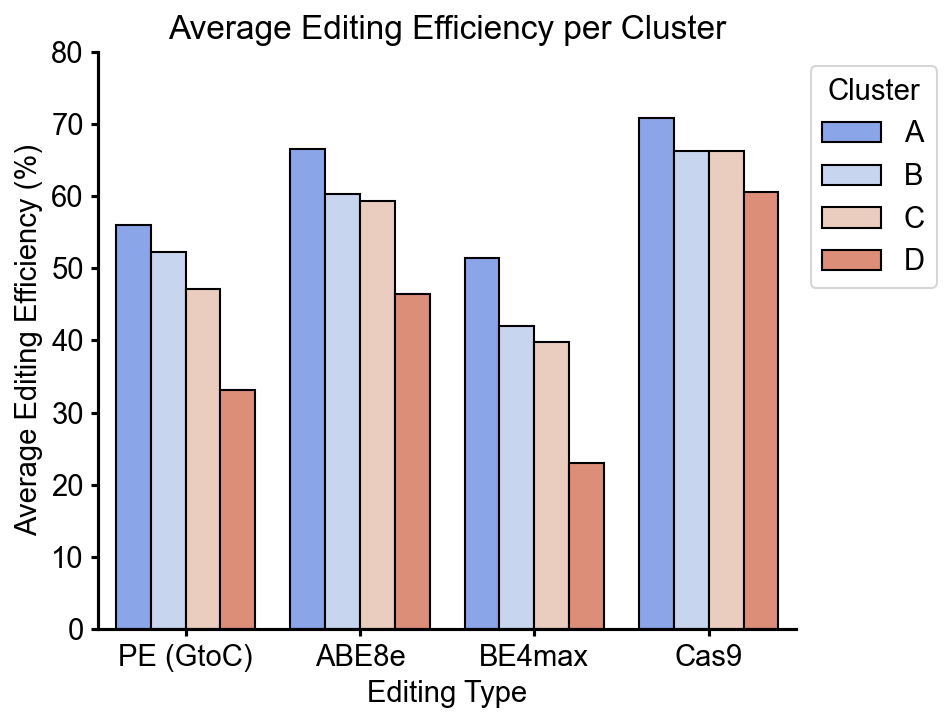

In [31]:
# List of columns and their corresponding names
columns = ['PE_edited_corrected_percentage',
           'ABE8e_total_edited_corrected_percentage',
           'BE4max_total_edited_corrected_percentage',
           'Cas9_modified_corrected_percentage']

names = ['PE (GtoC)', 'ABE8e','BE4max','Cas9']

# Create an empty DataFrame to store the averages for each column
averages_df = pd.DataFrame()
print(len(sub_encode_df))
# Iterate over the list of columns
for column, name in zip(columns, names):
    # Calculate the average for each cluster
    cluster_averages = sub_encode_df.groupby('cluster')[column].mean()

    # Count the number of elements in each cluster
    cluster_counts = sub_encode_df.groupby('cluster')[column].count()
    
    # Print out the count for each cluster for this editing type
    print(f"Number of elements in each cluster for {name}:")
    print(cluster_counts)

    # Add the averages to the DataFrame, creating a new column for each column in the list
    averages_df[name] = cluster_averages

# Reset the index of the DataFrame
averages_df.reset_index(inplace=True)

# Melt the DataFrame so that the column names become a single column
melted_df = averages_df.melt(id_vars='cluster', var_name='Editing Type', value_name='Average Editing Efficiency')

# Create a mapping dictionary from cluster number to alphabet
cluster_to_alpha = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}

# Replace cluster numbers with alphabets
melted_df['cluster'] = melted_df['cluster'].replace(cluster_to_alpha)

# Define the custom palette using the same colors as in the scatter plot
custom_palette = {label: color for label, color in zip(letter_labels, palette_colors)}


# Create a subplot to have better control over aesthetics
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)

# Create the bar plot
bar_plot = sns.barplot(x='Editing Type', y='Average Editing Efficiency', hue='cluster', 
                       data=melted_df, edgecolor='black', dodge=True, palette=custom_palette, ax=ax)

# Set axis labels and title with consistent font sizes
ax.set_xlabel('Editing Type', fontsize=14)
ax.set_ylabel('Average Editing Efficiency (%)', fontsize=14)
ax.set_title('Average Editing Efficiency per Cluster', fontsize=16)

# Set the Y-axis limits
ax.set_ylim(0, 80)

# Apply tick parameters for consistency
ax.tick_params(axis='x', labelsize=14, width=1.5)
ax.tick_params(axis='y', labelsize=14, width=1.5)

# Hide the right and top spines to match the first plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Customize the legend
ax.legend(bbox_to_anchor=(1, 1), ncol=1, title='Cluster', fontsize=14, title_fontsize=14)

# Show the plot
plt.show()


In [32]:
# Calculate the mean of each feature for each cluster
cluster_means = sub_encode_df.groupby('cluster')[features].mean()

# Calculate the overall mean of each feature
overall_means = sub_encode_df[features].mean()

# Calculate the difference between the cluster means and the overall means
# difference = cluster_means - overall_means
difference = ((cluster_means - overall_means) / overall_means)
# difference = cluster_means


# Define histone modifications
core_set = ["Dnase-seq","H3K79me2","CTCF",
                      "POLR2A","ATAC","H3K9ac","H3K9me3",
                      "H3K9me1","H4K20me1","BRD4","EZH2",
                      "H2AFZ","POLR2AphosphoS2","SMC3","HDAC1",
                      "HDAC2","HDAC3","H3K4me3","H3K4me2",
                      "H3K4me1","H3K27me3","H3K27ac","H3K36me3"]


# For each cluster, print the top 10 features with the highest and lowest difference
for cluster in difference.index:
    print(f"Cluster {cluster}:\n")
    
    # Get the features with the largest positive difference
    top_features = difference.loc[cluster].sort_values(ascending=False).head(10)
    print(f"Top 10 features with highest difference compared to overall mean:\n{top_features}\n")
    
    # Get the features with the largest negative difference
    bottom_features = difference.loc[cluster].sort_values(ascending=True).head(10)
    print(f"Top 10 features with lowest difference compared to overall mean:\n{bottom_features}\n")

    # Get the features that contain any of the histone marks
    core_features = difference.loc[cluster][difference.columns[difference.columns.str.contains('|'.join(core_set))]].sort_values(ascending=True)
    print(f"Core features bottom10:\n{core_features.head(10)}\n")
    print(f"Core features top10:\n{core_features.tail(10)}\n")

Cluster A:

Top 10 features with highest difference compared to overall mean:
H3K4me3_ENCFF911JVK_average_value_100     1.827163
H3K4me3_ENCFF806YEZ_average_value_1000    1.822981
H3K4me3_ENCFF911JVK_average_value_1000    1.819509
H3K4me3_ENCFF806YEZ_average_value_100     1.807489
H3K4me3_ENCFF806YEZ_average_value_2000    1.791663
H3K4me3_ENCFF911JVK_average_value_2000    1.771702
H3K4me2_ENCFF959YJV_average_value_100     1.755882
H3K27ac_ENCFF849TDM_average_value_100     1.746348
RBFOX2_ENCFF821XXA_average_value_1000     1.690211
RBFOX2_ENCFF821XXA_average_value_2000     1.653893
Name: A, dtype: float64

Top 10 features with lowest difference compared to overall mean:
H3K27me3_ENCFF139KZL_average_value_1000   -0.503796
H3K27me3_ENCFF139KZL_average_value_2000   -0.483286
H3K27me3_ENCFF139KZL_average_value_100    -0.463200
H3K27me3_ENCFF139KZL_average_value_5000   -0.428149
H3K27me3_ENCFF242ENK_average_value_1000   -0.284617
H3K27me3_ENCFF242ENK_average_value_2000   -0.282863
H3K27me3_E

In [33]:
# Initialize an empty DataFrame to store the most extreme values for each core feature and cluster
most_extreme_df = pd.DataFrame()

# For each cluster, find the most "extreme" values for each core feature
for cluster in difference.index:
    print(f"Cluster {cluster}:\n")
    
    # Initialize an empty Series to store the most extreme values for this cluster
    most_extreme_values = pd.Series(dtype='float64')
    
    # Loop over each core feature
    for feature in core_set:
        
        # Filter the columns that contain the current core feature
        feature_columns = difference.columns[difference.columns.str.contains(feature)]
        
        # Skip this iteration if there are no such columns
        if feature_columns.empty:
            print(feature)
            continue
        
        # Extract the values for these columns for the current cluster
        feature_values = difference.loc[cluster, feature_columns]
        
        # Find the most extreme value (either positive or negative)
        most_extreme_value = feature_values.loc[feature_values.abs().idxmax()]
        
        # Add to the Series
        most_extreme_values[feature] = most_extreme_value
    
    # Sort the most extreme values and print them
    sorted_most_extreme_values = most_extreme_values.sort_values(ascending=False)
    print(f"Relative difference to library mean:\n{sorted_most_extreme_values}\n")
    
    # Optionally, add these values to the DataFrame for later use
    most_extreme_df[cluster] = sorted_most_extreme_values


Cluster A:

Relative difference to library mean:
H3K4me3            1.827163
H3K4me2            1.755882
H3K27ac            1.746348
H3K9ac             1.619554
H2AFZ              1.294908
Dnase-seq          1.257823
POLR2A             1.197529
H3K4me1            1.169755
H3K79me2           1.116851
ATAC               1.039539
HDAC1              0.716959
HDAC2              0.696818
BRD4               0.605371
POLR2AphosphoS2    0.441624
CTCF               0.428928
SMC3               0.284838
HDAC3              0.256862
H3K36me3           0.173098
H4K20me1           0.165521
H3K9me1            0.161525
EZH2               0.122727
H3K9me3            0.044201
H3K27me3          -0.503796
dtype: float64

Cluster B:

Relative difference to library mean:
H3K36me3           1.106453
POLR2A             0.912878
POLR2AphosphoS2    0.912878
H3K79me2           0.569512
H4K20me1           0.369370
H3K9me1            0.219525
H3K9me3           -0.064289
HDAC3             -0.068352
EZH2              

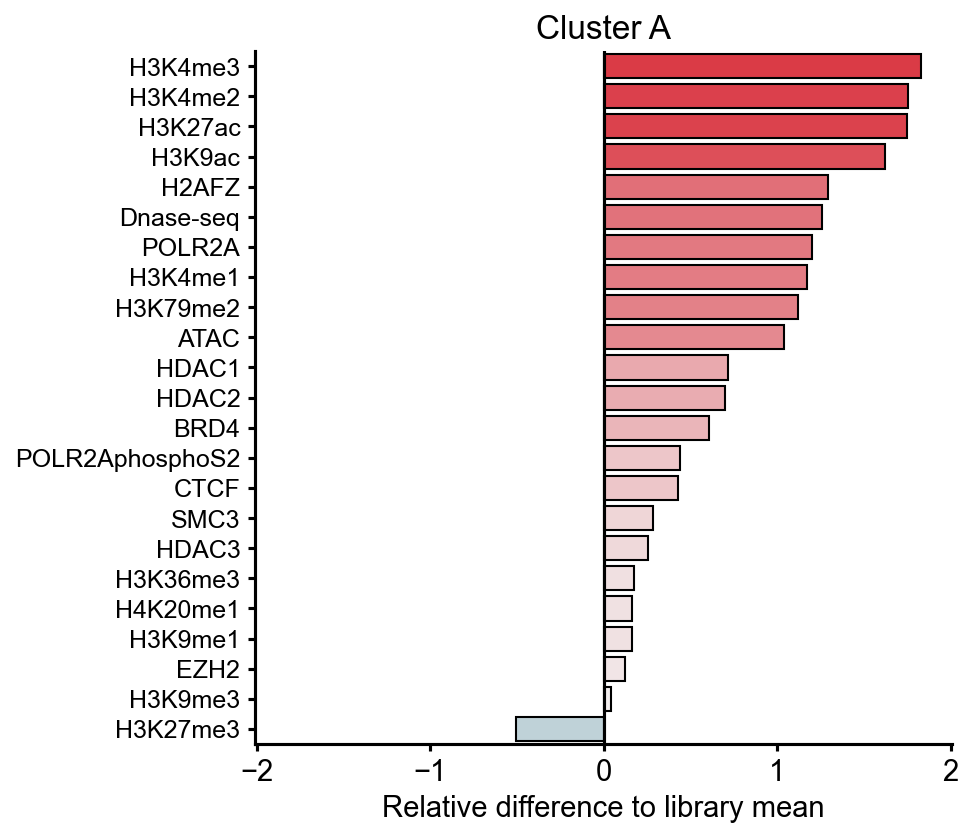

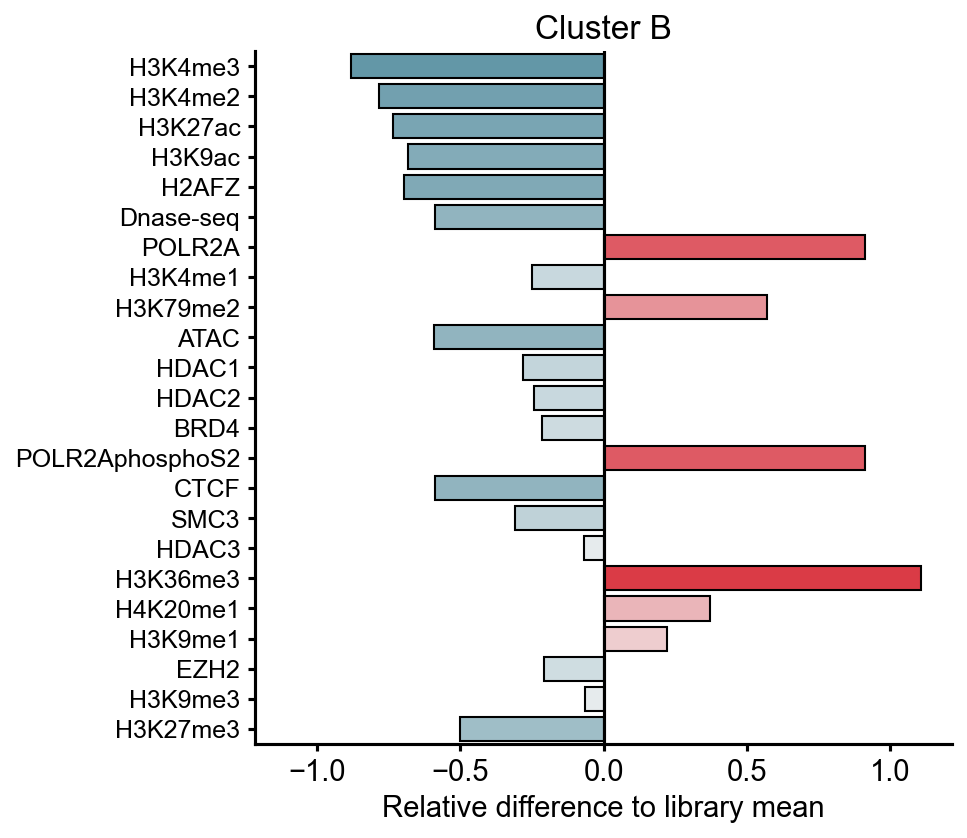

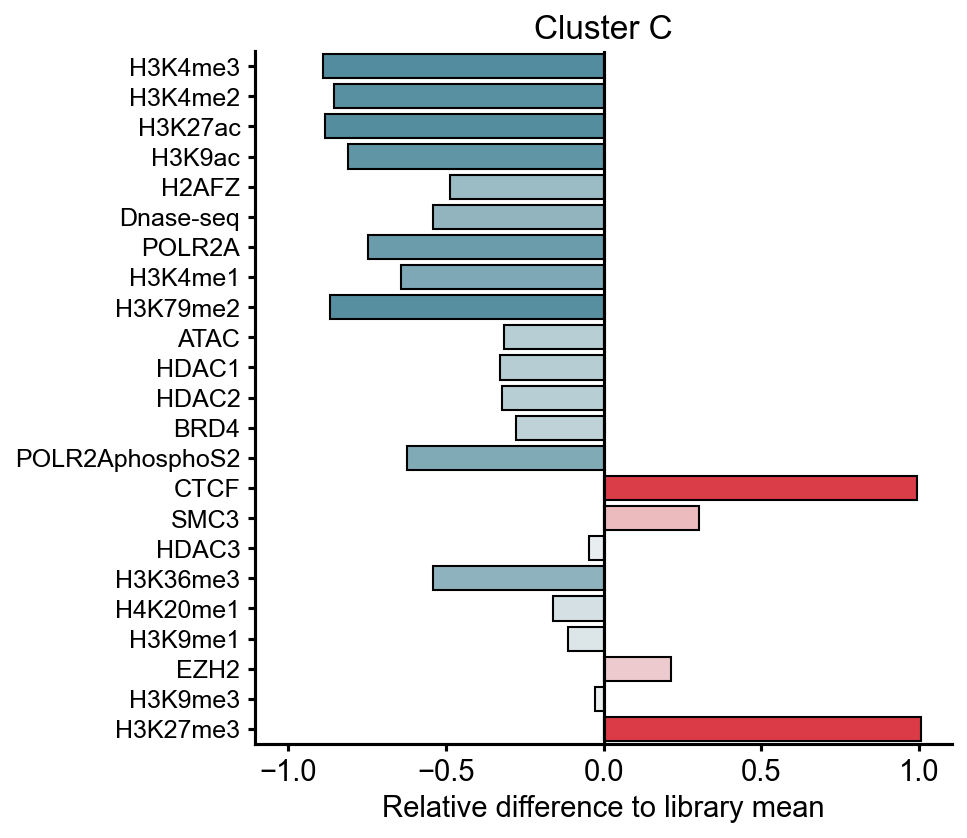

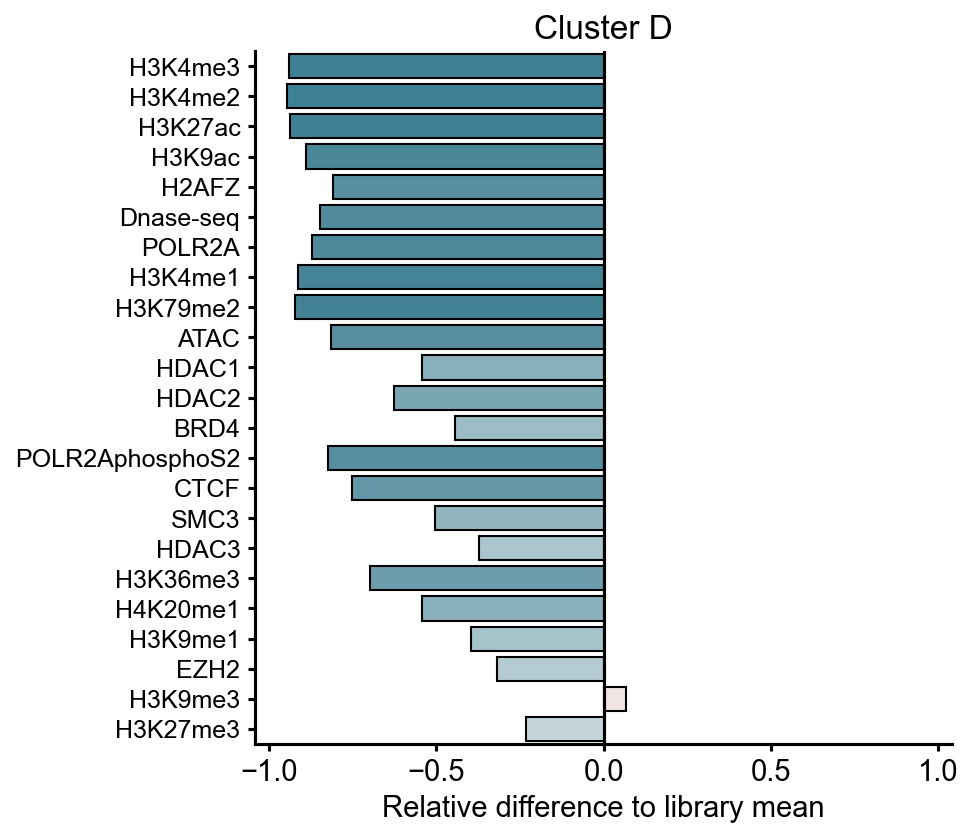

In [34]:
# Initialize a variable to store the order of features from the first plot
first_plot_order = None

# Create a colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Loop through each cluster in most_extreme_df
for cluster in most_extreme_df.columns:
    
    # Extract the data for the current cluster
    cluster_data = most_extreme_df[cluster].sort_values(ascending=False)
    
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(6, 6), dpi=150)
    
    # Plot the data in grey first
    barplot = sns.barplot(x=cluster_data, y=cluster_data.index, color="grey", edgecolor="black", order=first_plot_order)
    
    # If this is the first plot, save the order of features
    if first_plot_order is None:
        first_plot_order = cluster_data.index.tolist()
    
    # Iterate over the bars to set their color based on their value
    for i, bar in enumerate(barplot.patches):
        x_value = bar.get_width()
        color = cmap(0.5 + 0.5 * (x_value / max(abs(cluster_data.min()), cluster_data.max())))
        bar.set_facecolor(color)
    
    # Add a vertical line at x=0
    plt.axvline(0, color='black')
    
    # Determine the maximum absolute value in the data to set x-axis limits
    max_abs_value = max(abs(cluster_data.min()), abs(cluster_data.max())) * 1.1
    
    # Set x-axis limits to be symmetrical around 0
    ax.set_xlim(-max_abs_value, max_abs_value)
    
    # Add a legend and informative axis label
    # ax.set(ylabel="", xlabel="Relative difference to library mean", fontsize=14)
    ax.set_title(f"Cluster {cluster}", fontsize=16)

    # Apply tick parameters for consistency
    ax.tick_params(axis='x', labelsize=14, width=1.5)
    ax.tick_params(axis='y', labelsize=12, width=1.5)
    ax.set_xlabel('Relative difference to library mean', fontsize=14)

    
    sns.despine()
    plt.show()


#### Load in Li et al. dataset

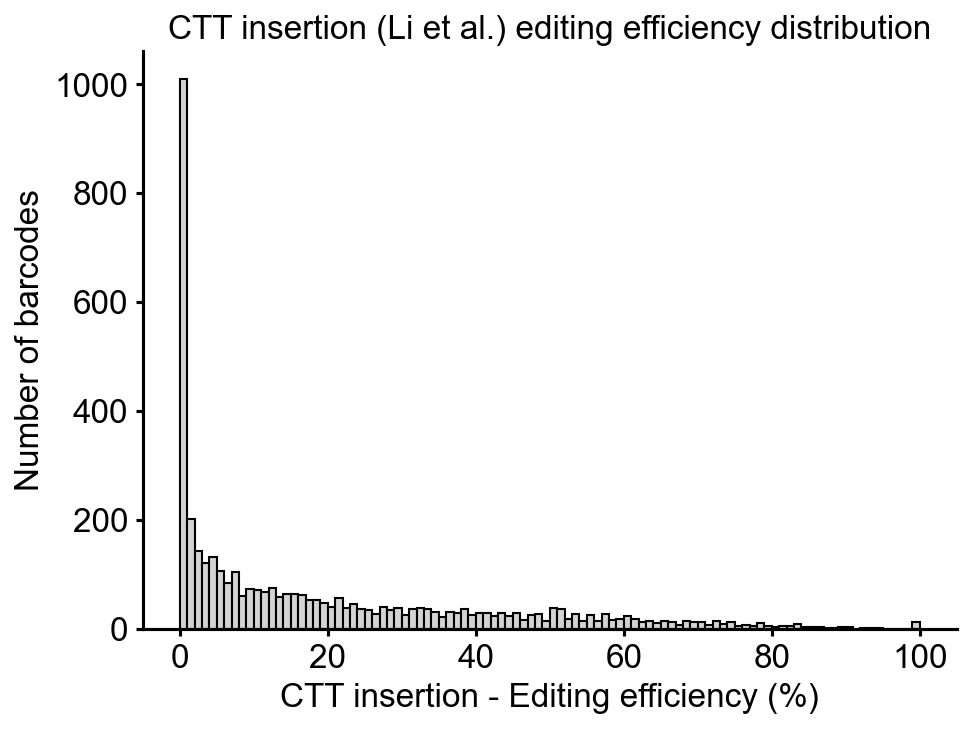

Average CTT insertion frequency:  19.296986975787515


In [35]:
# Analysis of Li et al. preprint data:
path = './05_External/01_Shendure/geo_datasets/'
filename = 'GSE228463_T7-500-1_processed.csv'
li_mapping_chromatindf = pd.read_csv(path+filename)
li_mapping_chromatindf = li_mapping_chromatindf.set_index('barcode')
li_features = ['DHS', 'H3K79me2', 'CTCF', 'POLR2A', 'ATAC', 'H3K9ac', 'H3K9me3',
       'H3K9me1', 'H4K20me1', 'BRD4', 'EZH2', 'H2AFZ', 'POLR2AS2', 'SMC3',
       'HDAC1', 'HDAC2', 'HDAC3', 'H3K4me3', 'H3K4me2', 'H3K4me1', 'H3K27me3',
       'H3K27ac', 'H3K36me3']

# also get chromatin marks from ENCODE (our own in-house script)
path = "./01_TRIP_pool/02_Analysis/Chromatin_Marks/results/"
li_full_encode_df = pd.read_csv(path+'Li_et_al_mappings_chromatinfeatures.csv')
li_full_encode_df = li_full_encode_df.set_index('barcode')
# remove columns "chromosome" and "position" from li_full_encode_df
li_full_encode_df = li_full_encode_df.drop(columns=['chromosome', 'position'])

# add all columns from li_full_encode_df to li_mapping_chromatindf based on the index (barcode)
li_mapping_chromatindf = li_mapping_chromatindf.join(li_full_encode_df, how='left')


column_mapping = {}

# Iterate through the columns in encode_df
for column in li_mapping_chromatindf.columns:
    # Iterate through the rows in encode_details
    for index, row in encode_details.iterrows():
        title = row['Title']
        target_label = row['Target label']
        assay_name = row['Assay term name']
        
        if assay_name == 'ATAC-seq':  # Add ATAC-seq to the column name if it is ATAC-seq (not Target label)
            target_label = row['Assay term name']
        
        if title in column:
            #print(title)
            #print(target_label)
            new_column_name = target_label + '_' + column
            column_mapping[column] = new_column_name
            break

# Rename columns using the column_mapping dictionary
li_mapping_chromatindf = li_mapping_chromatindf.rename(columns=column_mapping)

# Multiply 'insCTT_freq' by 100
li_mapping_chromatindf['insCTT_freq'] = li_mapping_chromatindf['insCTT_freq']*100

# Set the figure size and DPI
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)

# Plot the histogram
ax.hist(li_mapping_chromatindf['insCTT_freq'], bins=100, range=(0, 100), color='lightgrey', edgecolor='black', linewidth=1)

# Label the axes and set the title with specific font size
ax.set_xlabel('CTT insertion - Editing efficiency (%)', fontsize=16)
ax.set_ylabel('Number of barcodes', fontsize=16)
ax.set_title('CTT insertion (Li et al.) editing efficiency distribution', fontsize=16)

# Set tick parameters
ax.tick_params(axis='x', labelsize=16, width=1.5)
ax.tick_params(axis='y', labelsize=16, width=1.5)

# Remove top and right borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show the plot
plt.show()

# Print the average
print("Average CTT insertion frequency: ", li_mapping_chromatindf['insCTT_freq'].mean())

In [39]:
editcols = ["PE_edited_corrected_percentage", "ABE8e_total_edited_corrected_percentage", "BE4max_total_edited_corrected_percentage", "Cas9_modified_corrected_percentage"]
names = ['PE (GtoC)', 'ABE8e','BE4max','Cas9']

# Initialize an empty DataFrame to store results
encoderanking_df_all = pd.DataFrame()

for edittype, name in zip(editcols, names):
    # get all columns in encode_df that contain any of the strings in the list "core_set" within the column name itself
    featurecols = [column for column in encode_df.columns if any(feature in column for feature in core_set)]

    # only keep the columns which also contain the quantification window declared below in the column name
    quantification_window = '5000'
    final_featurecols = [column for column in featurecols if quantification_window in column]
    
    # filter encode_df to keep the columns which contain final_featurecols but also the editcols
    filtered_encode_df = encode_df[final_featurecols + [edittype]]
    
    # Drop rows containing NaNs
    filtered_encode_df_no_na = filtered_encode_df.dropna()
    
    # Print the length of the filtered and cleaned source DataFrame for this edittype
    print(f"Length of filtered and cleaned source DataFrame for {name}: {len(filtered_encode_df_no_na)}")
    
    # filter encode_df to keep the columns which contain final_featurecols but also the editcols
    encoderanking = encode_df[final_featurecols+editcols].corr('pearson')[edittype].sort_values(ascending=False)
    
    # remove "PE_edited_corrected_percentage", "BE4max_total_edited_corrected_percentage", "ABE8e_total_edited_corrected_percentage", "Cas9_modified_corrected_percentage" and "PE_unintended_editing_corrected_percentage" from the list
    encoderanking = encoderanking.drop(editcols)

    # Convert the Series to DataFrame
    encoderanking_df = encoderanking.reset_index()

    # Rename the columns for better understanding
    encoderanking_df.columns = ['Feature', 'Correlation']

    # Add a column for edittype
    encoderanking_df['Edit Type'] = name

    for index, row in encoderanking_df.iterrows():
            # print(row.Feature)
            encode_feature = row.Feature.split('_')[0]
            encoderanking_df.at[index, 'feature_short'] = encode_feature


    # First, let's calculate the absolute value of the correlation
    encoderanking_df['abs_correlation'] = encoderanking_df['Correlation'].abs()

    # Then, sort the dataframe by 'feature_short' and 'abs_correlation' in descending order
    encoderanking_df_sorted = encoderanking_df.sort_values(by=['feature_short', 'abs_correlation'], ascending=[True, False])

    # Drop duplicates in 'feature_short', keeping only the first occurrence (which has the highest 'abs_correlation')
    encoderanking_df_deduplicated = encoderanking_df_sorted.drop_duplicates(subset='feature_short', keep='first')

    encoderanking_df = encoderanking_df_deduplicated.sort_values(by='Correlation', ascending=False)

    # concat to the final DataFrame
    encoderanking_df_all = pd.concat([encoderanking_df_all, encoderanking_df], ignore_index=True)

Length of filtered and cleaned source DataFrame for PE (GtoC): 1182
Length of filtered and cleaned source DataFrame for ABE8e: 1169
Length of filtered and cleaned source DataFrame for BE4max: 1194
Length of filtered and cleaned source DataFrame for Cas9: 1196


meta NOT subset; don't know how to subset; dropped


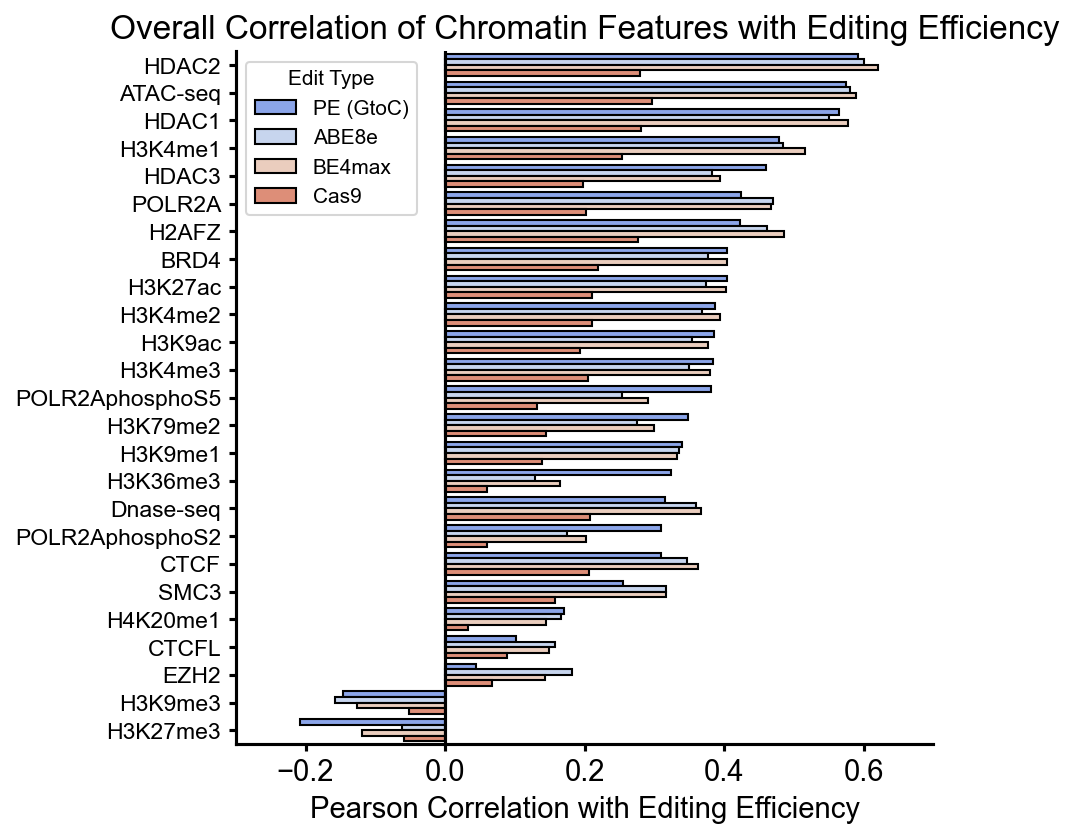

In [40]:
# Initialize the matplotlib figure with consistent dimensions
f, ax = plt.subplots(figsize=(6, 6), dpi=150)

# Create a colormap
cmap = sns.color_palette("coolwarm", len(names))

# Plot the correlations with colors from the colormap
sns.barplot(x="Correlation", y="feature_short", hue="Edit Type", data=encoderanking_df_all, palette=cmap, edgecolor="black")

# Add a vertical line at x=0
plt.axvline(0, color='black')

# Set title with consistent font size
plt.title('Overall Correlation of Chromatin Features with Editing Efficiency', fontsize=16)

# Set axis labels with consistent font sizes
ax.set(xlim=(-0.3, 0.7), ylabel="", xlabel="Pearson Correlation with Editing Efficiency")
ax.set_xlabel("Pearson Correlation with Editing Efficiency", fontsize=14)

# Apply tick parameters for consistency
ax.tick_params(axis='x', labelsize=14, width=1.5)
ax.tick_params(axis='y', labelsize=11, width=1.5)

# Remove the top and right spines to match the first plot
sns.despine()

# Save the plot if needed
plt.savefig("../03_DiseaseScreen/07_NewLibraries/08_Paper/01_Figures/Main_2_ePRIDICT/20230816_Overall_correlation_of_chromfeatures_editing.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

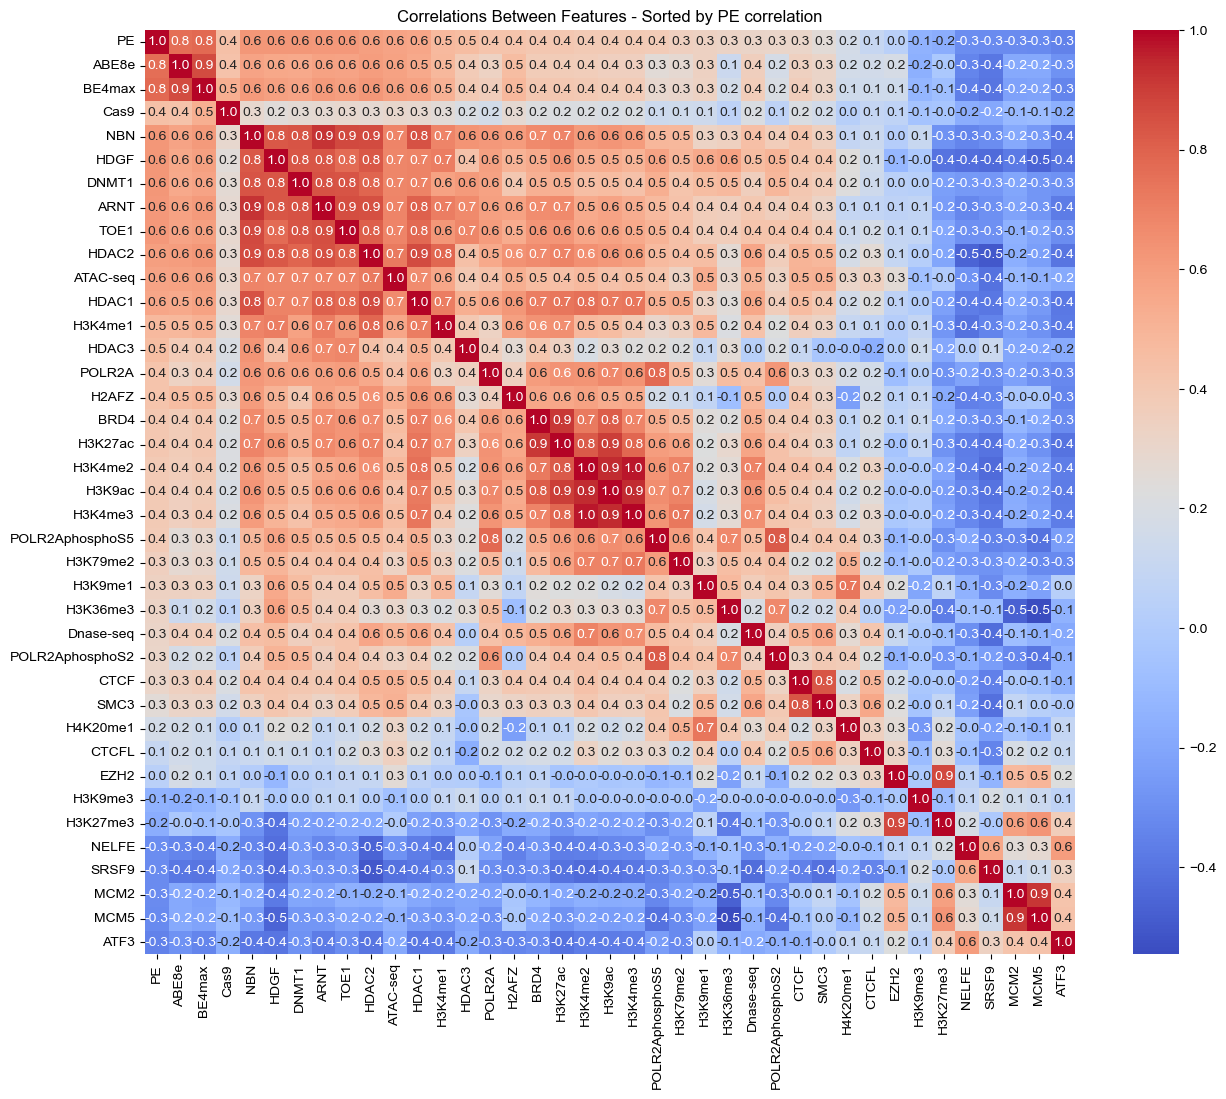

In [41]:
editcols = ["PE_edited_corrected_percentage", "ABE8e_total_edited_corrected_percentage", "BE4max_total_edited_corrected_percentage", "Cas9_modified_corrected_percentage"]
names = ['PE (GtoC)', 'ABE8e','BE4max','Cas9']

corr_matrix = encode_df.corr('pearson')
sorted_corr_matrix = corr_matrix.sort_values(by='PE_edited_corrected_percentage', ascending=False)
# remove rows where index is in editcols
sorted_corr_matrix = sorted_corr_matrix.drop(editcols)
# get the index names of the top and bottom 5 rows
top5 = list(sorted_corr_matrix.head(5).index)
bottom5 = list(sorted_corr_matrix.tail(5).index)


featurecols = [column for column in encode_df.columns if any(feature in column for feature in core_set)]

# only keep the columns which also contain the quantification window declared below in the column name
quantification_window = '5000'
final_featurecols = [column for column in featurecols if quantification_window in column]

# filter encode_df to keep the columns which contain final_featurecols but also the editcols
corr_matrix = encode_df[final_featurecols+editcols].corr('pearson')

# Calculate correlations for 'PE_edited_corrected_percentage' and create DataFrame
encoderanking = corr_matrix['PE_edited_corrected_percentage'].sort_values(ascending=False)
encoderanking_df = encoderanking.reset_index()
encoderanking_df.columns = ['Feature', 'Correlation']

# Add 'feature_short' and 'abs_correlation' columns
encoderanking_df['feature_short'] = encoderanking_df['Feature'].apply(lambda x: x.split('_')[0])
encoderanking_df['abs_correlation'] = encoderanking_df['Correlation'].abs()

# Drop duplicates in 'feature_short', keeping only the first occurrence (which has the highest 'abs_correlation')
encoderanking_df_sorted = encoderanking_df.sort_values(by=['Correlation'], ascending=[False])
encoderanking_df_deduplicated = encoderanking_df_sorted.drop_duplicates(subset='feature_short', keep='first')
encoderanking_df_deduplicated = encoderanking_df_deduplicated.reset_index()

# Exclude features from editcols
highest_corr_cols = [f for f in encoderanking_df_deduplicated['Feature'].tolist() if f not in editcols]

# Order columns
ordered_cols = editcols + top5 +  highest_corr_cols + bottom5

corr_matrix = encode_df.corr('pearson')

# Create a smaller correlation matrix that only includes the most correlated features
small_corr_matrix = corr_matrix.loc[ordered_cols, ordered_cols]

def trim_after_underscore(s):
    return s.split("_", 1)[0]

small_corr_matrix.index = small_corr_matrix.index.map(trim_after_underscore)
small_corr_matrix.columns = small_corr_matrix.columns.map(trim_after_underscore)

# Create a heatmap to visualize the small correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(small_corr_matrix, annot=True, fmt='.1f', cmap='coolwarm')
plt.title("Correlations Between Features - Sorted by PE correlation")
plt.show()

#### Determine highest and lowest ranking loci in our dataset

In [42]:
editingcollist = ['PE_edited_corrected_percentage', 'ABE8e_totaledited_corrected_percentage', 'BE4max_totaledited_corrected_percentage', 'Cas9_modified_corrected_percentage']
rankingdf = df.copy()
# create ranking for each column in the editingcollist within rankingdf
# create new column with the ranking by adding "_rank" to the columnname
for column in editingcollist:
    rankingdf[column+"_rank"] = rankingdf[column].rank(ascending=False)

# create a sum column for the ranking of the columns 'PE_edited_corrected_percentage', 'ABE8e_total_edited_corrected_percentage', 'BE4max_total_edited_corrected_percentage'
rankingdf['sum_rank_PE_BE'] = rankingdf['PE_edited_corrected_percentage_rank'] + rankingdf['ABE8e_totaledited_corrected_percentage_rank'] + rankingdf['BE4max_totaledited_corrected_percentage_rank']

# sort by the sum_rank_PE_BE column
rankingdf = rankingdf.sort_values(by='sum_rank_PE_BE')
# remove NaN in sum_rank_PE_BE column
rankingdf = rankingdf[rankingdf['sum_rank_PE_BE'].notna()]

path = "./02_Arrayed/cloning/top_bottom_locations/"
rankingdf.to_csv(path+'20230417_top_bottom_edited_locations_overview.csv', index=False)

# print the chromosome and position of the top 10 rows
print('Top 10 editing locations (PE/BE):\n',rankingdf.head(10)[['chromosome','position','sum_rank_PE_BE']])

# print the chromosome and position of the bottom 10 rows
print('Bottom 10 editing locations (PE/BE):\n',rankingdf.tail(10)[['chromosome','position','sum_rank_PE_BE']])

Top 10 editing locations (PE/BE):
                  chromosome   position  sum_rank_PE_BE
barcode                                               
CTACCCTTCTGCAACC      chr21   14762784            47.0
CTCCGCGTGATTGGTA      chr10   17655923            55.0
TCGCGATAATCCGCTA       chr4  139173391            55.0
CTAGAAGGTTCGCTCA       chr7   12402341            69.0
CCCCCCAAGCGCGGGT       chr2  208544310            97.0
CTGGGTCACACCCTTC       chr1   50971796            99.0
GGTTACTGGTGACTCC       chr3    9400868           103.0
ATATGCCTGCTATCGC      chr12   62604259           113.0
CCCATAAACAAACGGA       chr6   85596107           120.0
GAATGACGCACCTATC       chr6   43427429           121.0
Bottom 10 editing locations (PE/BE):
                  chromosome   position  sum_rank_PE_BE
barcode                                               
ATTCATGCCTAGTATC       chrX   95338480          3486.0
CACGTGATCTTGCCTC       chrX   14268081          3487.0
GTCTTTTTCCTAGGCT      chr12   78313867         

#### Save datasets for ML analysis

In [43]:
# datasets based on Schwank data but with different set of features:
path = './04_Paper/02_github/epridict/datasets_for_ml/chromatin/'
encode_df.to_csv(path+'encode_df.csv')

# datasets based on Li et al. data:
li_mapping_chromatindf.to_csv(path+'li_mapping_chromatindf.csv')